In [1]:
## !jt -t chesterish  # set given theme
#!jt -r # reset default theme

# Conference on the Future of Europe Dataset
## An application of agglomerative clustering and polarisation evaluation on real bimodal networks
### Adrián Fernández Cid

## Outline
### 1. Data and unimodal projection
### 2. Clustering and polarisation
### 3. Dendogram/tree topologic distances for different $\alpha$
### 4. The pipeline

## 1. Data and unimodal projection

The Conference on the Future of Europe is ... 
The online platform for the CFE (from where the data was retrieved, https://futureu.europa.eu/?locale=en) allows European citizens, groups or even official representatives to propose and vote "ideas" (that one can follow or endorse), organise and attend events ("meetings"), or leave comments on any of the two, among other things.

At the time the data was collected for this project, the Xth December 2021 at xxxx (GMT+1), there were a total of some 40 000 participants, 11 000 proposals and 50 000 proposal endorsements by users. The data, which include information on proposals, meetings and their respective comments, presents the opportunity to reproduce the analysis performed in **SouthernWomen.ipynb** on a (to the best of my knowledge) yet unstudied topical issue: the bimodal network is here composed of proposals and endorsers (instead of of women and events), allowing to search insight on such a participatory process.

Data from https://futureu.europa.eu/?locale=en.

Download link: https://futureu.europa.eu/open-data/download.

Let us load and check the data. As mentioned above, the data includes information on proposals, meetings and comments to eiither of them:

**proposals** -> each row is a proposal with names of endorsers, number of followers and of supports and many other columns, most of them multilingual versions

**meetings** -> same as proposals but with meetings (with some different columns)

**proposal_comments** -> contains textuaL user comments on some proposals 

**meeting_comments** -> contains textuaL user comments on some meetings 

but we're only interested in the proposal information.

The proposal data seen below seem quite complete. Although we will only need the id, title, body and endorsers of each proposal, we will do a little exploration.

In [1]:
import pandas as pd
file = "proposals"#proposals, meetings, proposal_comments, meeting_comments
df = pd.read_csv("../data/FutureOfEuropeConf/futureu.europa.eu-open-data-"+
                 file+".csv", low_memory=False
                , sep=";")
print(df.shape)
df.head()

(9261, 213)


id  category/id                                   category/name/bg  \
0    1705          7.0  Ефективно използване на ресурсите за кръгова и...   
1    1481          4.0      Осигуряване на справедлив и приобщаващ преход   
2   30661          4.0      Осигуряване на справедлив и приобщаващ преход   
3   98145          4.0      Осигуряване на справедлив и приобщаващ преход   
4  115043          NaN                                                NaN   

                                   category/name/cs  \
0  Účinné využívání zdrojů pro oběhové hospodářství   
1   Zajištění spravedlivé a inkluzivní transformace   
2   Zajištění spravedlivé a inkluzivní transformace   
3   Zajištění spravedlivé a inkluzivní transformace   
4                                               NaN   

                                    category/name/da  \
0  Effektiv anvendelse af ressourcer til en cirku...   
1     Sikring af en retfærdig og inklusiv omstilling   
2     Sikring af en retfærdig og inklusiv omstilling   
3     Sikring af en retfærdig og inklusiv omstilling   
4                                                NaN   

                                    category/name/de  \
0   Ressourceneffizienz für eine Kreislaufwirtschaft   
1  Sicherstellung eines gerechten und inklusiven ...   
2  Sicherstellung eines gerechten und inklusiven ...   
3  Sicherstellung eines gerechten und inklusiven ...   
4                                                NaN   

                                    category/name/el  \
0                         Αποδοτική χρήση των πόρων    
1  Εξασφάλιση δίκαιης και χωρίς αποκλεισμούς μετά...   
2  Εξασφάλιση δίκαιης και χωρίς αποκλεισμούς μετά...   
3  Εξασφάλιση δίκαιης και χωρίς αποκλεισμούς μετά...   
4                                                NaN   

                                    category/name/en  \
0  Using resources efficiently for a circular eco...   
1           Ensuring a fair and inclusive transition   
2           Ensuring a fair and inclusive transition   
3           Ensuring a fair and inclusive transition   
4                                                NaN   

                                    category/name/es  \
0  Utilizar los recursos de manera eficiente para...   
1        Garantizar una transición justa e inclusiva   
2        Garantizar una transición justa e inclusiva   
3        Garantizar una transición justa e inclusiva   
4                                                NaN   

                                    category/name/et  ... body/lv title/bg  \
0  Ressursside tõhus kasutamine puhta ringmajandu...  ...     NaN      NaN   
1      Õiglane ja kaasav jätkusuutlikkusele üleminek  ...     NaN      NaN   
2      Õiglane ja kaasav jätkusuutlikkusele üleminek  ...     NaN      NaN   
3      Õiglane ja kaasav jätkusuutlikkusele üleminek  ...     NaN      NaN   
4                                                NaN  ...     NaN      NaN   

  body/bg title/hr body/hr title/ga body/ga  \
0     NaN      NaN     NaN      NaN     NaN   
1     NaN      NaN     NaN      NaN     NaN   
2     NaN      NaN     NaN      NaN     NaN   
3     NaN      NaN     NaN      NaN     NaN   
4     NaN      NaN     NaN      NaN     NaN   

  category/name/machine_translations/fr category/name/machine_translations/pt  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   
3                                   NaN                                   NaN   
4                                   NaN                                   NaN   

  category/name/machine_translations/en  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3                                   NaN  
4                                   NaN  

[5 rows x 213 columns]

As expected from an EU platform, the proposals may be in any language of a member state. They are also optionally translated so that every user can vote and comment on every proposal, and the translations are included in the data. However, we are not interested here in text in languages other than English, so we will remove all non-English text columns:

In [2]:
print(df.shape)
multilingual_cols = ["category/name/",
"scope/name/",
"title/machine_translations/",
"body/machine_translations/",
"answer/",
"title/",
"body/",
"category/name/machine_translations/"]

count = 0
for col in df.columns:
    for m_col in multilingual_cols:
        if (m_col in col) and not("/en" in col) :
            #print(col)
            df.drop(columns=col, inplace=True)
            count += 1
            break #exit inner loop
print(df.columns)
print(count, df.shape)

(9261, 213)
Index(['id', 'category/id', 'category/name/en', 'scope/id', 'scope/name/en',
       'participatory_space/id', 'participatory_space/url', 'component/id',
       'title/machine_translations/en', 'body/machine_translations/en',
       'state', 'reference', 'answer/en', 'supports',
       'endorsements/total_count', 'endorsements/user_endorsements',
       'comments', 'attachments', 'followers', 'published_at', 'url',
       'meeting_urls', 'related_proposals', 'is_amend',
       'original_proposal/title', 'original_proposal/url', 'title/en',
       'body/en', 'category/name/machine_translations/en'],
      dtype='object')
184 (9261, 29)


An important reduction. Besides, some of the remaining columns only have missing values:

In [3]:
#drop columns that only have nans
df.dropna(axis=1, how="all", inplace=True)
print(df.shape)
df.columns

(9261, 23)


Index(['id', 'category/id', 'category/name/en', 'participatory_space/id',
       'participatory_space/url', 'component/id',
       'title/machine_translations/en', 'body/machine_translations/en',
       'state', 'reference', 'supports', 'endorsements/total_count',
       'endorsements/user_endorsements', 'comments', 'attachments',
       'followers', 'published_at', 'url', 'meeting_urls', 'is_amend',
       'title/en', 'body/en', 'category/name/machine_translations/en'],
      dtype='object')

In [4]:
for col in df.columns:
    print(f"======{col}======")
    print(df[col].unique())
"""df["supports"].unique()
df["state"].unique()
df["answer/en"].unique()
df["related_proposals"].unique()"""

======id======
[  1705   1481  30661 ... 113422 124312 124543]
======category/id======
[ 7.  4. nan  6. 16. 17. 15. 14. 12. 11. 13. 19. 18. 20.  1.  2.  3.  8.
 10.  9. 26. 23. 21. 24. 25. 22. 37. 35. 34. 36. 39. 38. 41. 40.]
======category/name/en======
['Using resources efficiently for a circular economy '
 'Ensuring a fair and inclusive transition' nan
 'Restoring biodiversity and cutting pollution'
 'Promoting healthy lifestyles' 'Coronavirus' 'Healthcare'
 'Disinformation' 'Have your say on European Union policies'
 'Protecting our democracies' 'Media'
 'Boosting jobs, growth and investment'
 'A more inclusive and fairer economy' 'Coronavirus recovery'
 'European rights and values' 'Security' 'Consumer rights'
 'Technology for people' 'Digital economy' 'A sustainable digital society'
 'Security and defence' 'Development cooperation' 'Foreign policy'
 'Neighbourhood policy and enlarging the European Union' 'Trade policy'
 'Humanitarian aid and civil protection' 'Legal migration and

['http://futureu.europa.eu/processes/GreenDeal/f/1/proposals/1705'
 'http://futureu.europa.eu/processes/GreenDeal/f/1/proposals/1481'
 'http://futureu.europa.eu/processes/GreenDeal/f/1/proposals/30661' ...
 'http://futureu.europa.eu/processes/Education/f/36/proposals/113422'
 'http://futureu.europa.eu/processes/Education/f/36/proposals/124312'
 'http://futureu.europa.eu/processes/Education/f/36/proposals/124543']
======meeting_urls======
[nan 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/515'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/37852'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/53101'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/24751'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/47026'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/30031'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/3169'
 'http://futureu.europa.eu/processes/GreenDeal/f/2/meetings/2213'
 'http://futureu.europ

'df["supports"].unique()\ndf["state"].unique()\ndf["answer/en"].unique()\ndf["related_proposals"].unique()'

In [5]:
pd.set_option('display.max_columns', None)
df.head()

id  category/id                                   category/name/en  \
0    1705          7.0  Using resources efficiently for a circular eco...   
1    1481          4.0           Ensuring a fair and inclusive transition   
2   30661          4.0           Ensuring a fair and inclusive transition   
3   98145          4.0           Ensuring a fair and inclusive transition   
4  115043          NaN                                                NaN   

   participatory_space/id                            participatory_space/url  \
0                       2  http://futureu.europa.eu/processes/GreenDeal?p...   
1                       2  http://futureu.europa.eu/processes/GreenDeal?p...   
2                       2  http://futureu.europa.eu/processes/GreenDeal?p...   
3                       2  http://futureu.europa.eu/processes/GreenDeal?p...   
4                       2  http://futureu.europa.eu/processes/GreenDeal?p...   

   component/id                      title/machine_translations/en  \
0             1  Reducing climate impact through a security arc...   
1             1  Eolien vs NUCLEAIRE, for a real European taxon...   
2             1                                                NaN   
3             1  Use national schemes such as the Civic Service...   
4             1  The European Union must promote the introducti...   

                        body/machine_translations/en state  \
0  One of the European Union’s problems is that i...   NaN   
1  At present, the EU refuses to take nuclear ene...   NaN   
2                                                NaN   NaN   
3  On the occasion of the Citizens’ Dialogue “Rai...   NaN   
4  Proposal of participants in the event of 5 Oct...   NaN   

                  reference  supports  endorsements/total_count  \
0    cofe-PROP-2021-04-1705         0                         1   
1    cofe-PROP-2021-04-1481         0                         8   
2   cofe-PROP-2021-06-30661         0                         3   
3   cofe-PROP-2021-09-98145         0                         2   
4  cofe-PROP-2021-10-115043         0                         0   

                      endorsements/user_endorsements  comments  attachments  \
0                        Felix Thomas Mendner-Mattes         1            2   
1  F R, Leo Prada, Simon Schmidt, Jean MELOT, Han...        23            0   
2  Chiara Margaretha Przybilla, David Haverlant, ...         1            0   
3                    Bernard Gueniot, Chloé Vantorre         0            0   
4                                                NaN         0            0   

   followers             published_at  \
0        742  2021-04-30 15:39:57 UTC   
1        746  2021-04-27 08:42:14 UTC   
2        744  2021-06-17 10:45:22 UTC   
3        744  2021-09-20 10:04:30 UTC   
4        743  2021-10-07 20:59:01 UTC   

                                                 url  \
0  http://futureu.europa.eu/processes/GreenDeal/f...   
1  http://futureu.europa.eu/processes/GreenDeal/f...   
2  http://futureu.europa.eu/processes/GreenDeal/f...   
3  http://futureu.europa.eu/processes/GreenDeal/f...   
4  http://futureu.europa.eu/processes/GreenDeal/f...   

                                        meeting_urls  is_amend  \
0                                                NaN     False   
1                                                NaN     False   
2  http://futureu.europa.eu/processes/GreenDeal/f...     False   
3  http://futureu.europa.eu/processes/GreenDeal/f...     False   
4  http://futureu.europa.eu/processes/GreenDeal/f...     False   

                                            title/en  \
0                                                NaN   
1                                                NaN   
2  Better Define what is Green, Social or Sustain...   
3                                                NaN   
4                                                NaN   

                                             body/en  \
0                

In [6]:
df["endorsements/user_endorsements"][2], df["followers"][2], df["supports"][5]

('Chiara Margaretha Przybilla, David Haverlant, Bernadette Lauro', 744, 0)

Let us look at the available topics:

In [7]:
df["category/name/en"].unique()

array(['Using resources efficiently for a circular economy ',
       'Ensuring a fair and inclusive transition', nan,
       'Restoring biodiversity and cutting pollution',
       'Promoting healthy lifestyles', 'Coronavirus', 'Healthcare',
       'Disinformation', 'Have your say on European Union policies',
       'Protecting our democracies', 'Media',
       'Boosting jobs, growth and investment',
       'A more inclusive and fairer economy', 'Coronavirus recovery',
       'European rights and values', 'Security', 'Consumer rights',
       'Technology for people', 'Digital economy',
       'A sustainable digital society', 'Security and defence',
       'Development cooperation', 'Foreign policy',
       'Neighbourhood policy and enlarging the European Union',
       'Trade policy', 'Humanitarian aid and civil protection',
       'Legal migration and integration', 'Integrated Border Management',
       'Asylum and Migration', 'Deepening international cooperation',
       'Culture', 'E

Interesting topics (because they are expected to be controversial or I don't know and want to see + some presumably uncontroversial ones for control):

In [8]:
 topics = ['Restoring biodiversity and cutting pollution',
         'Coronavirus', 'Healthcare',
           'Disinformation', 
           'Protecting our democracies', 
           'A more inclusive and fairer economy', 'Coronavirus recovery',
    'Security', 'Security and defence',
       'Legal migration and integration', 'Integrated Border Management',
       'Asylum and Migration', 
       'Culture', 'Education', 'Sport', 'Youth ']

We will pass each one of these through the analysis pipeline.

Let us check how many available proposals we have for each topic, namely with the condition of being originally posted in English. This is to make sure there are no spurious distance or polarisation effects due to language, but we may remove the condition because Emanuele says they seem not to be relevant:

In [9]:
for t in topics:
    subdf = df[(df["category/name/en"]==t)
            & (df["endorsements/user_endorsements"].notna()) 
              #& (df["reference"].notna())
               & (df["title/en"].notna())
              ] 
    if subdf.shape[0] < 10000:
        print(f"{subdf.shape[0]} proposals in {t}")


79 proposals in Restoring biodiversity and cutting pollution
15 proposals in Coronavirus
45 proposals in Healthcare
5 proposals in Disinformation
101 proposals in Protecting our democracies
104 proposals in A more inclusive and fairer economy
9 proposals in Coronavirus recovery
20 proposals in Security
35 proposals in Security and defence
25 proposals in Legal migration and integration
3 proposals in Integrated Border Management
49 proposals in Asylum and Migration
27 proposals in Culture
72 proposals in Education
1 proposals in Sport
10 proposals in Youth 


We do not want amends to avoid spurious endorser overlap, but none of the proposals seems to be an amend, so we're ok:

In [10]:
df["is_amend"].unique()

array([False])

We make a function to create a subdf with a given topic:

In [11]:
cols_to_keep = ['id','body/en', 
           'body/machine_translations/en',
            'title/machine_translations/en',
           'state', 'reference', #'answer/en', 
                'supports',
           'endorsements/total_count', 'endorsements/user_endorsements',
            'followers',# 'related_proposals', 
                'is_amend', 'title/en']
def df_by_topic(topic, cols_to_keep):
    subdf = df[(df["category/name/en"]==topic)  
               & (df["endorsements/user_endorsements"].notna()) 
              & (df["reference"].notna())
              & (df["title/en"].notna())
              ].copy()
    subdf = subdf[cols_to_keep]
    return subdf
#print(subdf.columns)

In [12]:
subdf = df_by_topic("Security", cols_to_keep)
subdf.head(2)

id                                            body/en  \
5819  994  The criminal justice is currently ruled by 27 ...   
5858  189  In 2007, at the Munich conference, V. Putin an...   

     body/machine_translations/en title/machine_translations/en state  \
5819                          NaN                           NaN   NaN   
5858                          NaN                           NaN   NaN   

                  reference  supports  endorsements/total_count  \
5819  cofe-PROP-2021-04-994         0                        13   
5858  cofe-PROP-2021-04-189         0                         2   

                         endorsements/user_endorsements  followers  is_amend  \
5819  Benoît Michau, Joris Lijssens, Felicia S, Samu...        574     False   
5858                                      Lara Goeree,         575     False   

                                               title/en  
5819  Unify European crime justice and scale up Europol  
5858                          International impeachment

In [13]:
for t, b in zip(subdf['title/en'],subdf["body/en"]):
    print(f"============{t}==========")
    print (b)

============Unify European crime justice and scale up Europol==========
The criminal justice is currently ruled by 27 different jurisdictions and enforced by 27 different police forces, which makes it difficult for Europol to fight terrorism, money laundering and human trafficking, while other crimes are difficult to address cross border.
If criminals can enjoy Schengen, a single European crime justice must be established based on a common criminal low, EU appointed juges and significant police forces acting everywhere in EU. This could be achieved if countries tranfer some of their police headcount to Europol. Europol would then be much more visible to citizens and benefit from a better media coverage for its landmark accomplishments (everyone currently believes our local police forces did it alone).
Obviously, EU juges and Europol would remain funded and supervised by the European Commission.
============International impeachment==========
In 2007, at the Munich conference, V. Putin 

And now a function to retrieve the nodes (and the two dictionaries relevant for buiding the net) from a given df:

In [14]:
import numpy as np
def get_nodes(subdf):
    proposals = list(subdf["id"])
    endorsers = []
    prop_endorsers = subdf["endorsements/user_endorsements"]
    prop2end = {i:j for i, j in zip(proposals, prop_endorsers)}
    for prop in prop_endorsers:
        for user in prop.split(", "):
            endorsers.append(user)
    print(f"Total number of endorsers: {len(endorsers)}")
    endorsers = np.unique(endorsers)
    print(f"Number of unique endorsers: {len(endorsers)}")
    print(f"Number of proposals: {len(proposals)}")

    y = endorsers 
    x = proposals 
    x2y = prop2end
    ny = len(y)
    x2vect = {xi:[0]*ny for xi in x}
    for xi in x:
        for i, yi in enumerate(y):
            if yi in x2y[xi]:
                x2vect[xi][i] = 1
    #print(x2vect[x[0]])
    return x, y, x2vect, x2y

In [15]:
x, y, x2vect, x2y = get_nodes(subdf)

Total number of endorsers: 195
Number of unique endorsers: 134
Number of proposals: 20


x2y contains all y (endorsers) linked to every x (proposals), while x2vect contains a binary feature vector per x, the vector corresponding to the linking value (yes:1, no:0) of the x to the corresponding y. 

Although it seems more intuitive to project the bimodal network on endorsers rather than on proposals, it is a technical constraint that the number of the former is usually much larger than that of the latter. Additionally, performing the analysis on proposals allows to make qualitative sense of the results by actually reading and evaluating them, which cannot be done with anonymous endorsers, and any appreciative polarisation in the system should be present for both proposals and endorsers (albeit with a relation that is not self-evident).

Function to build the bimodal network:

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def bimodal_net(x, y, x2y, fname2save=None):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(y, bipartite=0)
    B.add_nodes_from(x, bipartite=1)

    #add edges
    for xi in x: 
        for yi in x2y[xi]:
            B.add_edge(xi, yi)

    #pos = nx.fruchterman_reingold_layout(B);
    pos = nx.drawing.layout.bipartite_layout(B, x);
    #pos = nx.drawing.layout.circular_layout(B);#ugly
    #pos = nx.drawing.layout.kamada_kawai_layout(B);#ugly

    
    plt.figure(figsize=(8,8));
    plt.axis("off");
    nx.draw_networkx_nodes(x, pos, node_size=30, node_color="green");
    nx.draw_networkx_nodes(y, pos, node_size=30, node_color="blue");
    nx.draw_networkx_edges(B, pos, alpha=0.500);
    #nx.draw_networkx_labels(B, pos, font_color="white");
    if fname2save != None:
        plt.savefig(fname2save)
        print(f"File saved to {fname2save}!")
    plt.show()
    return B, pos

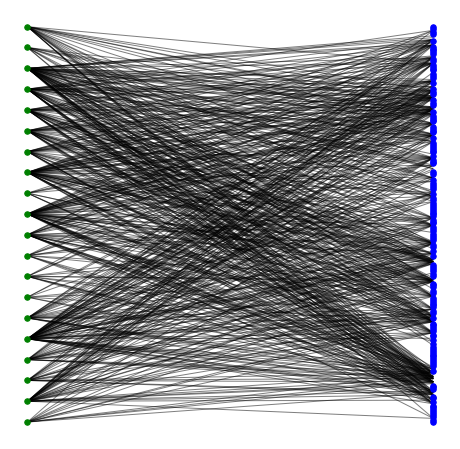

In [17]:
B, pos = bimodal_net(x, y, x2y)

Function to project the bimodal network onto a unimodal one (of proposals):

In [18]:
def unimodal_net(x, y, x2vect, pos=None, fname2save=None):
    U = nx.Graph()
    U.add_nodes_from(x)
    n_x = len(x)
    ny = len(y)
    #add edges
    for i, xi in enumerate(x):
        for y_idx in range(ny):
            if x2vect[xi][y_idx]==1:
                for j in range(i+1, n_x):
                    if x2vect[x[j]][y_idx]==1:
                        U.add_edge(xi, x[j])
    if pos == None:
        pos = nx.fruchterman_reingold_layout(U);
    plt.figure(figsize=(8,8));
    plt.axis("off");
    nx.draw_networkx_nodes(x, pos, node_size=100, node_color="green");
    nx.draw_networkx_edges(U, pos, alpha=0.500);
    #nx.draw_networkx_labels(U, pos, font_color="white");
    if fname2save != None:
        plt.savefig(fname2save)
        print(f"File saved to {fname2save}!")
    plt.show()

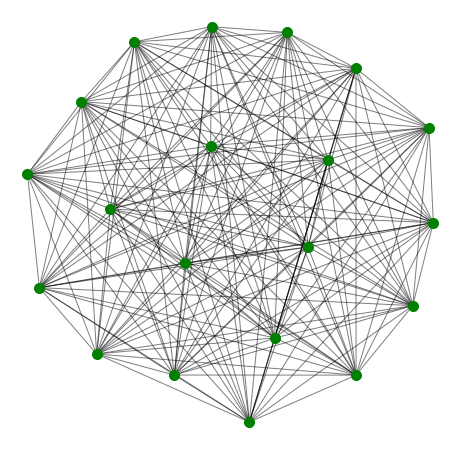

In [19]:
unimodal_net(x, y, x2vect)

## 2. Hierarchical clustering

As with the Southern Women dataset, we define the distance matrix between nodes through their pairwise phi-correlation, later turned into an Euclidean distance.

We define a function to implement the method in the pipeline:

In [20]:
from sklearn.metrics import matthews_corrcoef

#build normalised condensed distance matrix
def cond_dist_matrix(x, x2vect):
    phi = []
    nx = len(x)
    for i, xi in enumerate(x):
        vec_xi = x2vect[xi]
        for j in range(i+1, nx):
            vec_xj = x2vect[x[j]]  
            phi.append(matthews_corrcoef(vec_xi, vec_xj))
            #to check correlations are actually symmetric
            #print(matthews_corrcoef(vec_wi, vec_wj)
            #      , matthews_corrcoef(vec_wj,vec_wi))

    #the expected length is n(n-1)/2
    print(len(phi), nx*(nx-1)/2)
    #turn correlations to Euclidean distances (the phi are somewhat like the cosine)
    d = np.sqrt(2*(1-np.array(phi)))
    d /= max(d)
    print(d.shape)
    return d

d = cond_dist_matrix(x, x2vect)

190 190.0
(190,)


And check that the clustering works as expected:

In [21]:
#for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

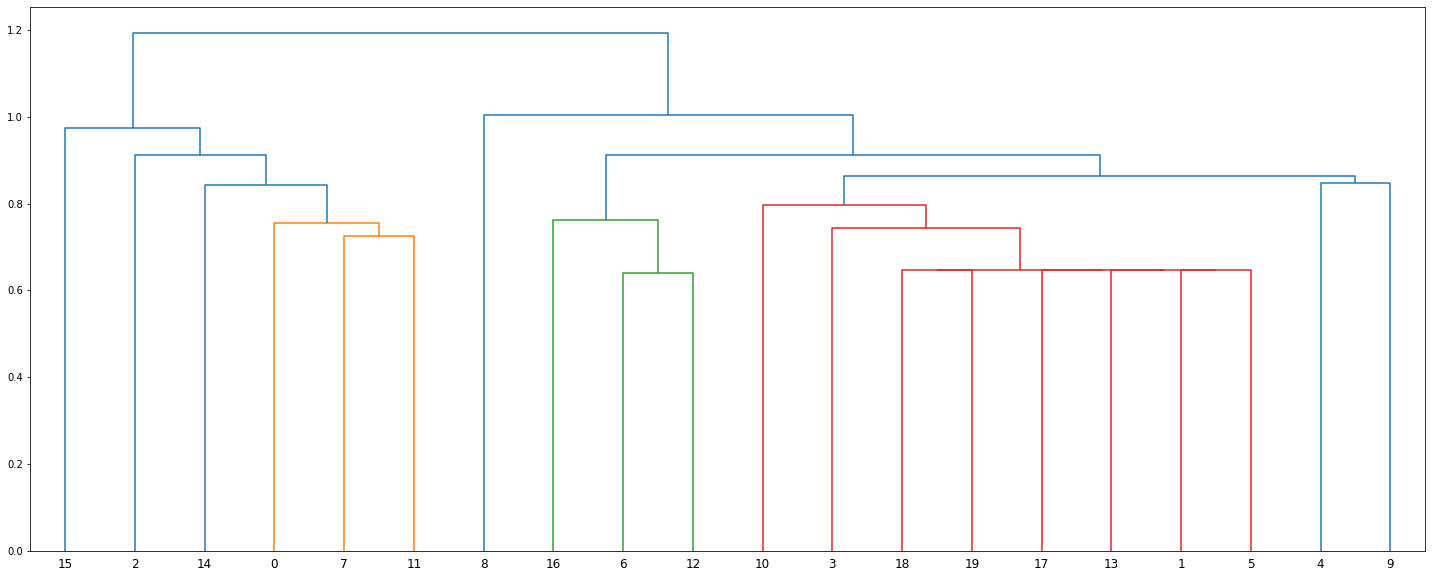

In [23]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_ward, _ = agglomerative_clustering(d, method='ward')
#print(z_ward.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_ward)
plt.show()

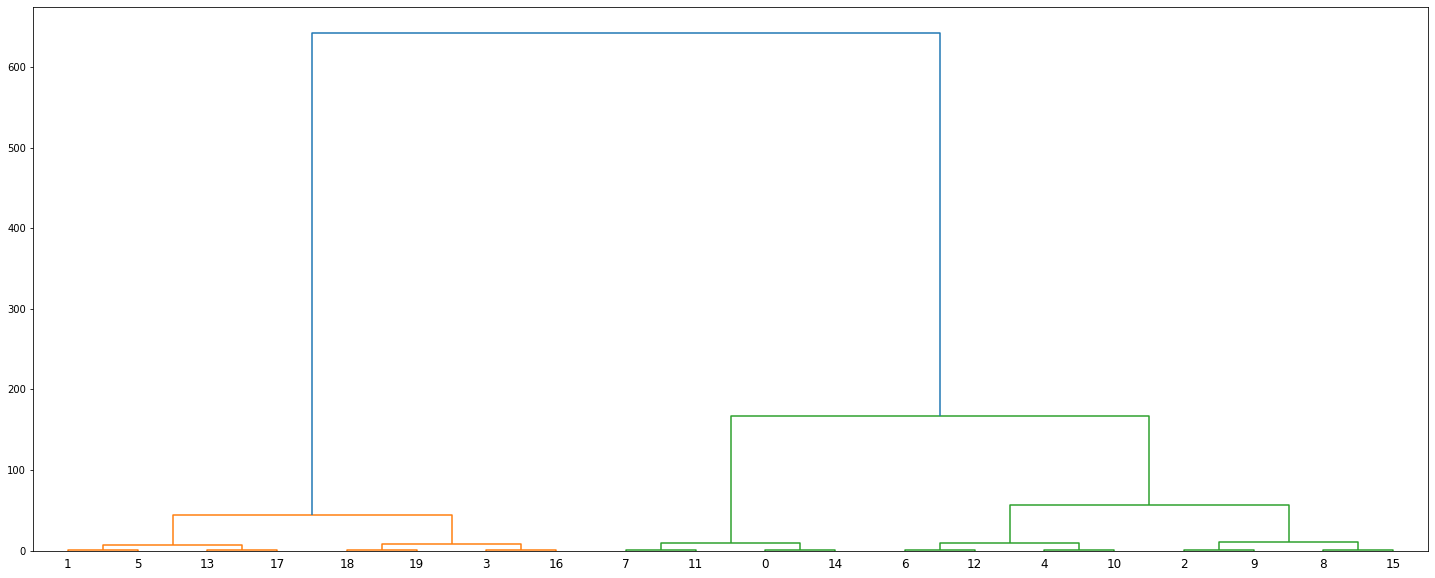

In [24]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_pol, pol = agglomerative_clustering(d, method='polarisation', alpha=1, K=None)
#print(z_pol.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_pol)
plt.show()

(19,)


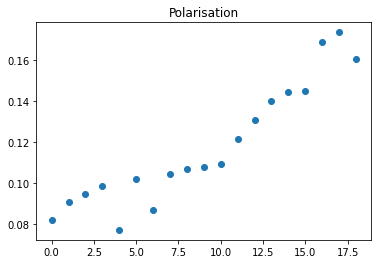

In [25]:
from matplotlib import pyplot as plt
print(pol.shape)
plt.plot(pol, "o")
plt.title("Polarisation")
plt.show()

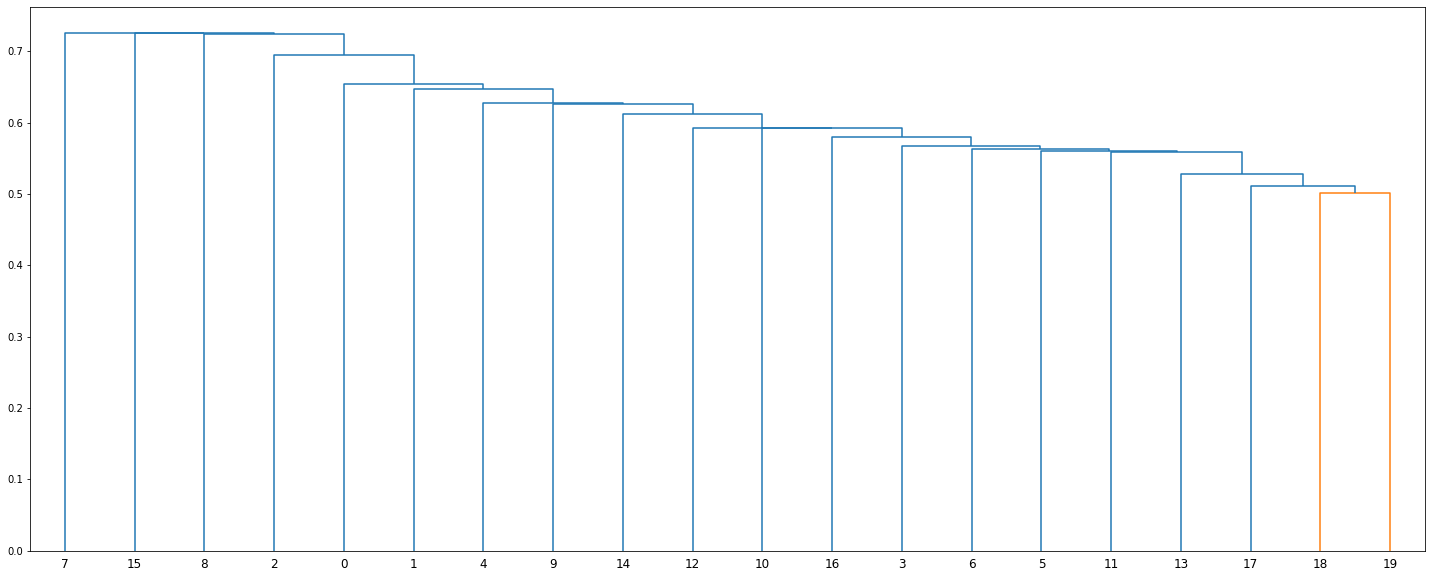

In [26]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_ctr, pol = agglomerative_clustering(d, method='centroid', alpha=1, K=None)
#print(z_ctr.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_ctr)
plt.show()

Everything seems to be working. Let us define the tree distance measurements and pass all the topics through the whole pipeline.

## 3. Dendogram/tree topologic distances for different $\alpha$

Let's check the tree distance between the Ward, polarisation and centroid-obtained dendograms for every topic of interest. As in **SouthernWomen.ipynb**, I use the library *dendropy*.

In [27]:
#!pip install dendropy

Function to produce dendogram/tree string in Newick format from a linkage matrix:

In [28]:
import dendropy

def z_to_tree_str_newick(z, x):
    tree_str = ""
    clusters = x
    idx2x = {i:str(xi) for i, xi in enumerate(x)}#str(xi) when using id as x
    x2idx = {str(xi):i for i, xi in enumerate(x)}
    n = z.shape[0] + 1
    for i in range(n-1):
        #print(z[i, :2])
        new_clus = "(" + idx2x[int(z[i,0])] + "," + idx2x[int(z[i,1])] + ")"
        idx2x[int(i+n)] = new_clus
        #print(int(i+z.shape[0]))
    idx2x[int(i+n)] += ";"
    return idx2x[int(2*n-2)]

tree_str1 = z_to_tree_str_newick(z_ctr, x)
tree_str2 = z_to_tree_str_newick(z_pol, x)

print(f"{tree_str1}\n{tree_str2}")

(1035,(299,(117,(218,(994,(189,(8556,(12147,(1770,(67453,(46036,(80556,(103327,(17826,(10874,(1139,(85571,(4229,(96097,121408)))))))))))))))))));
((((189,10874),(85571,4229)),((96097,121408),(103327,80556))),(((1035,1139),(994,1770)),(((17826,67453),(8556,46036)),((218,12147),(117,299)))));


Function to compute the unweighted Robinson-Foulds distance between two trees given their strings in Newick format:

In [29]:
import dendropy
from dendropy.calculate import treecompare
def RF_dist(tree_str1, tree_str2):
    # trees need to have the same TaxonNamespace for RF distance
    tns = dendropy.TaxonNamespace()
    tree1 = dendropy.Tree.get_from_string(tree_str1, "newick",
            taxon_namespace=tns)
    tree2 = dendropy.Tree.get_from_string(tree_str2, "newick",
            taxon_namespace=tns)
    #have to compute bipàrtitions (whatever it means) of both trees 
    #before calling symmetric_difference
    tree1.encode_bipartitions()
    tree2.encode_bipartitions()
    #return unweighted RF distance
    return treecompare.symmetric_difference(tree1, tree2)

Produce and save plot of RF distances vs $\alpha$:

In [36]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering
def tree_dists(d, x, alphas=None):
    dist_p2c = []
    dist_p2w = []
    dist_p2p0 = []
    #alphas = np.arange(0,50,1)
    if alphas==None:
        alphas = np.arange(0,30,3)

    z_pol0, _ = agglomerative_clustering(d, method='polarisation'
                                              , alpha=0, K=None)
    tp0_str = z_to_tree_str_newick(z_pol0, x)

    for alpha in alphas:
        z_pol, _ = agglomerative_clustering(d, method='polarisation'
                                              , alpha=alpha, K=None)
        z_ctr, _ = agglomerative_clustering(d, method='centroid'
                                            ,alpha=1, K=None)#this alpha is for computing pol, not pol dist
        z_wrd, _ = agglomerative_clustering(d, method='ward')

        tp_str = z_to_tree_str_newick(z_pol, x)
        tc_str = z_to_tree_str_newick(z_ctr, x)
        tw_str = z_to_tree_str_newick(z_wrd, x)

        dist_p2c.append(RF_dist(tp_str, tc_str))
        dist_p2w.append(RF_dist(tp_str, tw_str))
        dist_p2p0.append(RF_dist(tp0_str, tp_str))
    return  dist_p2c, dist_p2w, dist_p2p0 

In [37]:
#alphas = np.arange(0,30,3)
dist_p2c, dist_p2w, dist_p2p0 = tree_dists(d, x)

In [37]:
#dist_p2p0, dist_p2c, dist_p2w

In [38]:
"_".join(topics[0].split(" "))

'Restoring_biodiversity_and_cutting_pollution'

In [39]:
from matplotlib import pyplot as plt
"""plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})"""
def dist_plots(alphas, dist_p2c, dist_p2w, dist_p2p0, title=None, fname2save=None):
    plt.plot(alphas, dist_p2c, "*-", label="p2c")
    plt.plot(alphas, dist_p2w, "--", label="p2w")
    plt.plot(alphas, dist_p2p0, ".-", label="p2p0")

    if title==None:
        title = "Topological (RF) tree distance vs alpha"
    plt.title(title)
    plt.xlabel("alpha")
    plt.ylabel("D_{RF}")
    plt.legend()
    if fname2save != None:
        plt.savefig(fname2save)
        print(f"File saved to {fname2save}!")
    plt.show()

File saved to ../plots/Security_rfdist_vs_alpha.png!


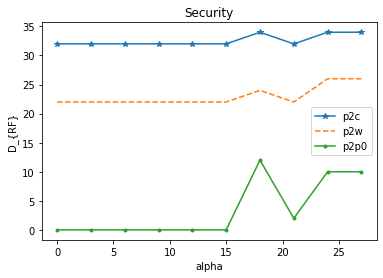

In [40]:
fname2save = "../plots/Security_rfdist_vs_alpha.png"
alphas = np.arange(0,30,3)
dist_plots(alphas, dist_p2c, dist_p2w, dist_p2p0, title="Security", fname2save=fname2save)

## 4. The pipeline

Now we can pass all interesting topics through the whole pipeline:

====== Restoring biodiversity and cutting pollution ======
Total number of endorsers: 786
Number of unique endorsers: 461
Number of proposals: 79
====== Coronavirus ======
Total number of endorsers: 54
Number of unique endorsers: 45
Number of proposals: 15
File saved to ../plots/Coronavirus_bim_net.png!


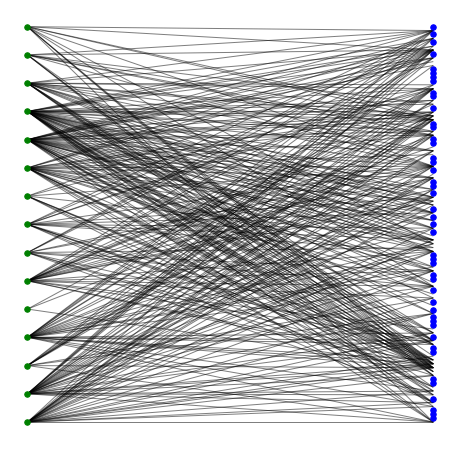

File saved to ../plots/Coronavirus_uni_net.png!


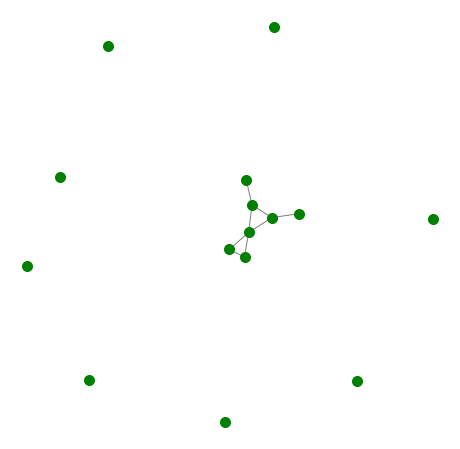

105 105.0
(105,)
****** WARD ******


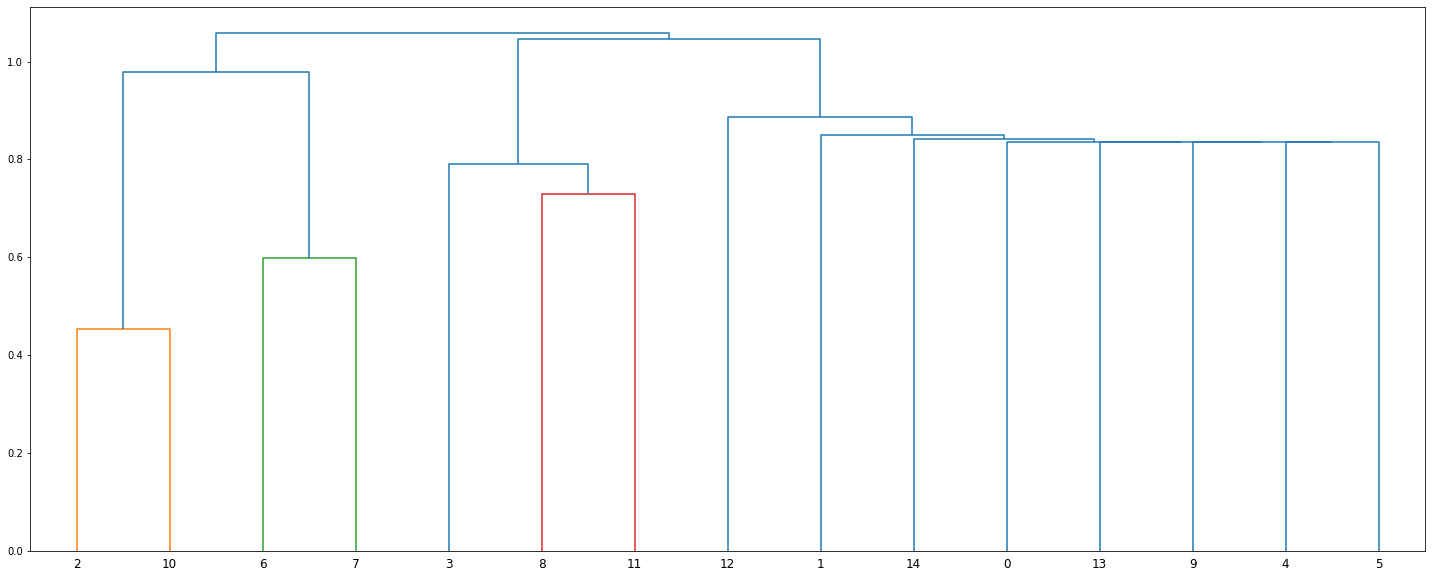

****** POLDIST ******


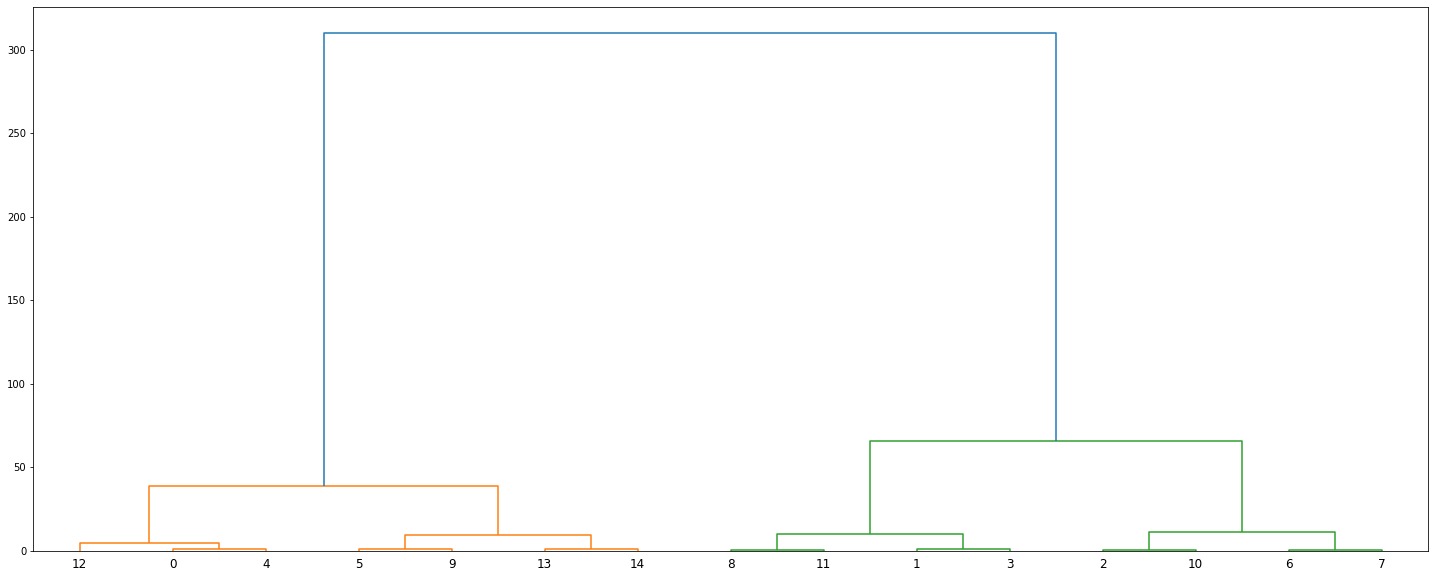

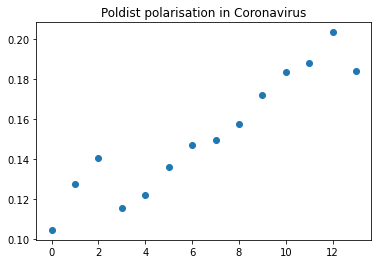

****** CENTROID ******
(14, 4)


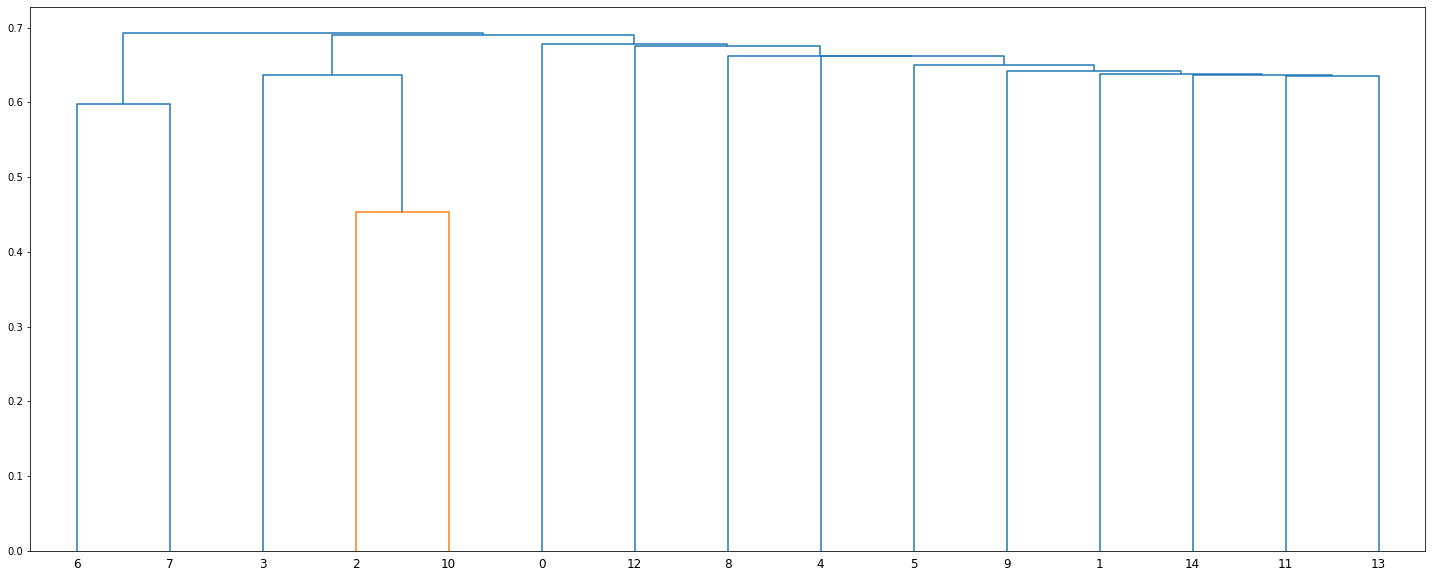

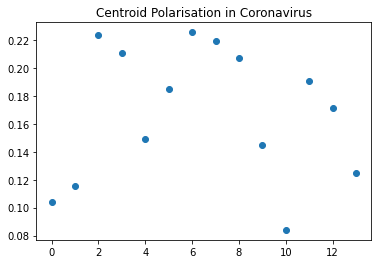

File saved to ../plots/Coronavirus_rfdist_vs_alpha.png!


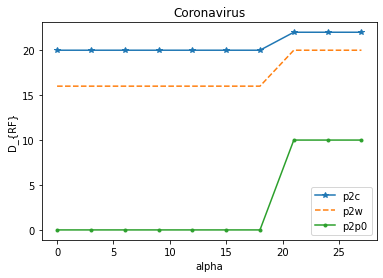

====== Healthcare ======
Total number of endorsers: 1162
Number of unique endorsers: 875
Number of proposals: 45
File saved to ../plots/Healthcare_bim_net.png!


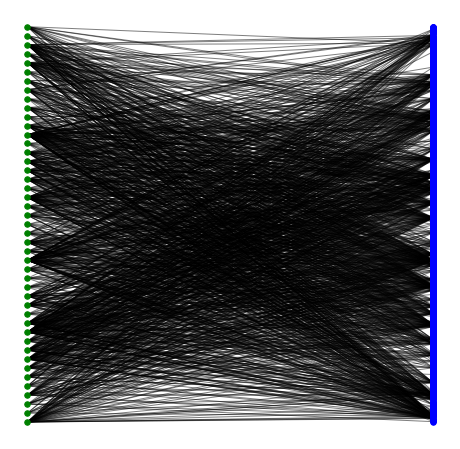

File saved to ../plots/Healthcare_uni_net.png!


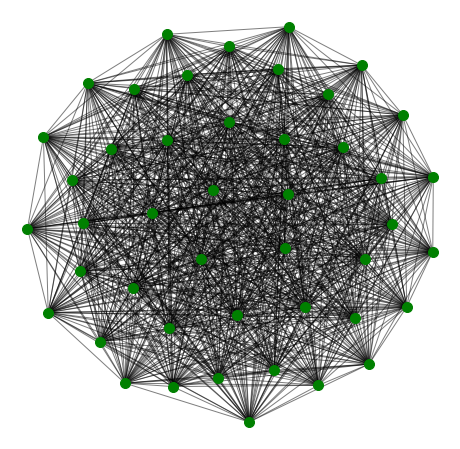

990 990.0
(990,)
****** WARD ******


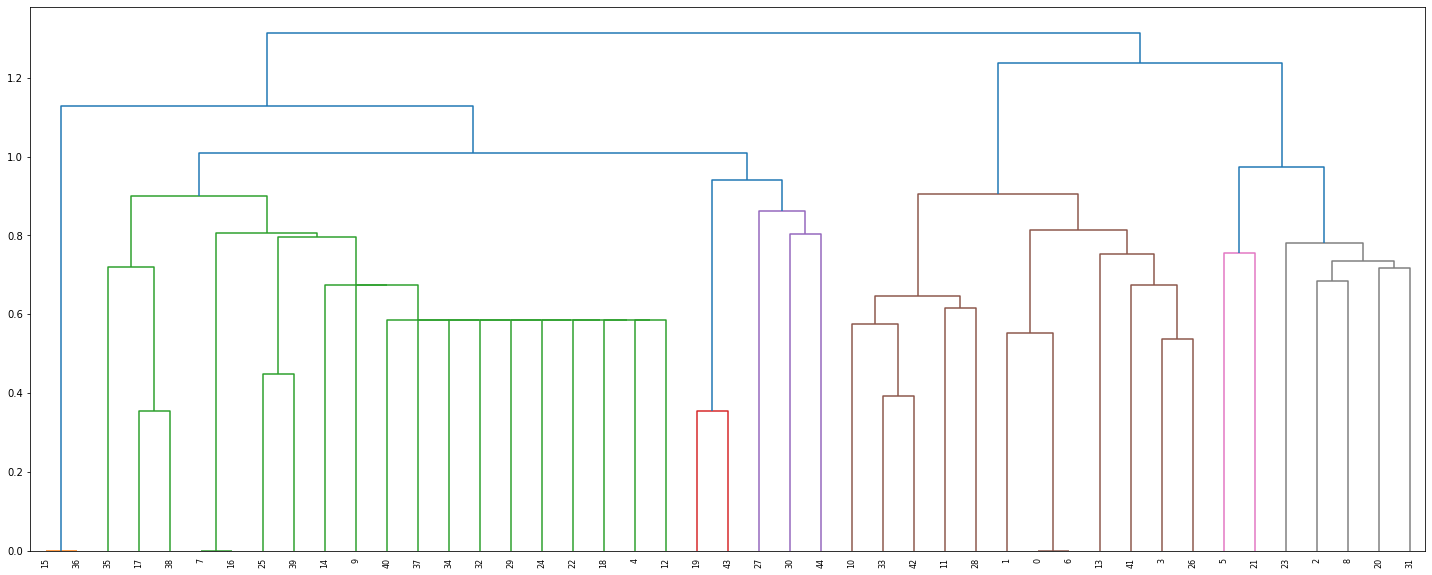

****** POLDIST ******


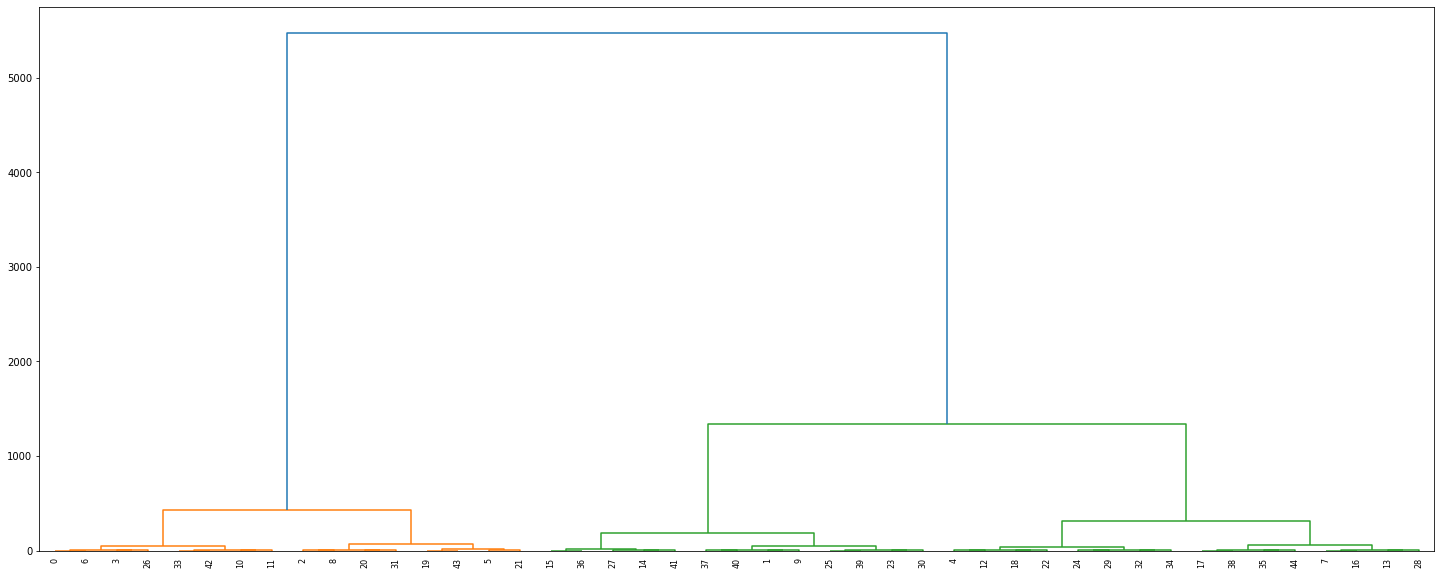

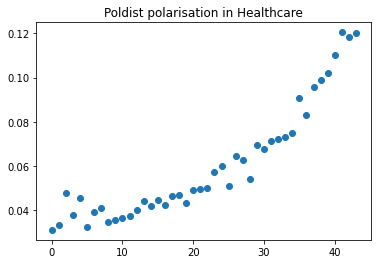

****** CENTROID ******
(44, 4)on 43/43...


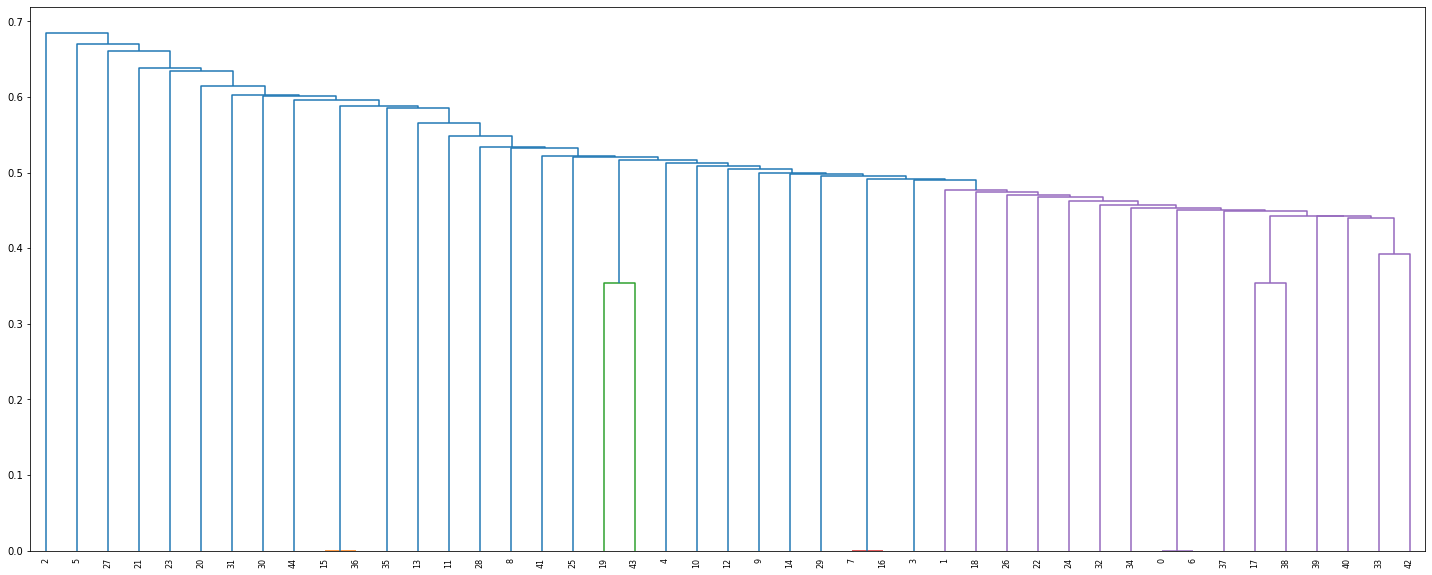

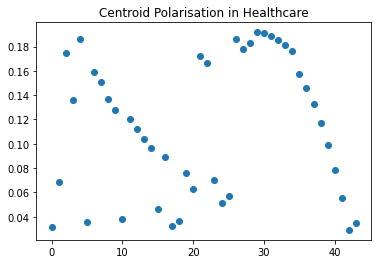

File saved to ../plots/Healthcare_rfdist_vs_alpha.png!


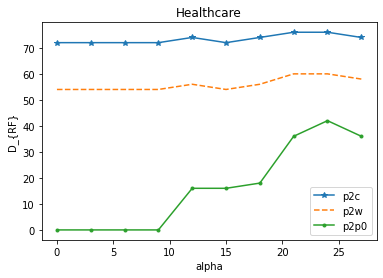

====== Disinformation ======
Total number of endorsers: 18
Number of unique endorsers: 18
Number of proposals: 5
====== Protecting our democracies ======
Total number of endorsers: 1006
Number of unique endorsers: 579
Number of proposals: 101
====== A more inclusive and fairer economy ======
Total number of endorsers: 892
Number of unique endorsers: 513
Number of proposals: 104
====== Coronavirus recovery ======
Total number of endorsers: 141
Number of unique endorsers: 128
Number of proposals: 9
====== Security ======
Total number of endorsers: 195
Number of unique endorsers: 134
Number of proposals: 20
File saved to ../plots/Security_bim_net.png!


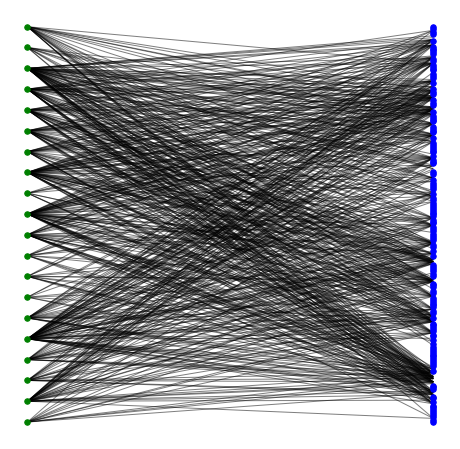

File saved to ../plots/Security_uni_net.png!


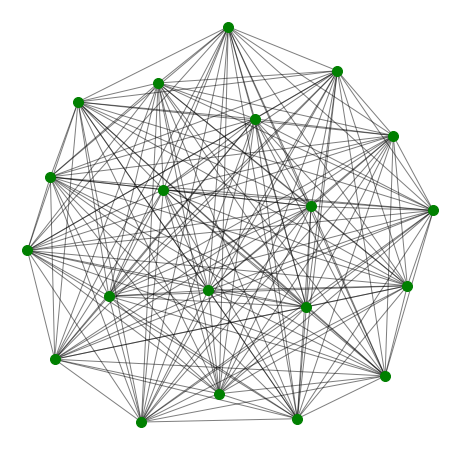

190 190.0
(190,)
****** WARD ******


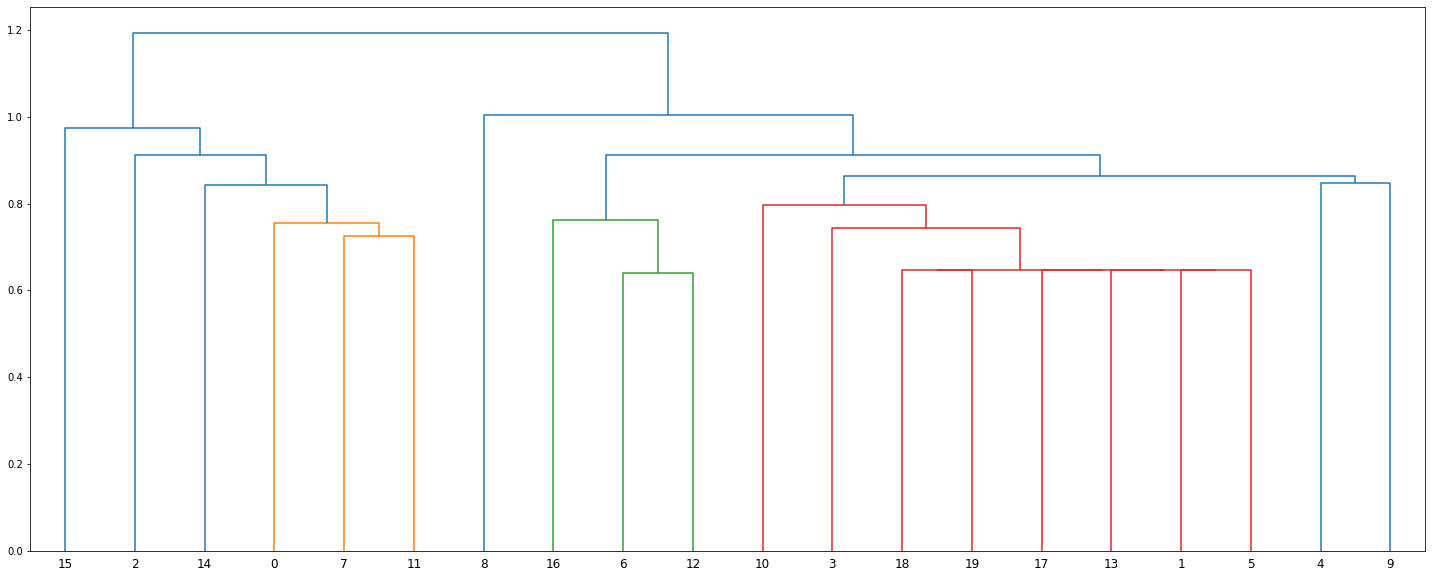

****** POLDIST ******


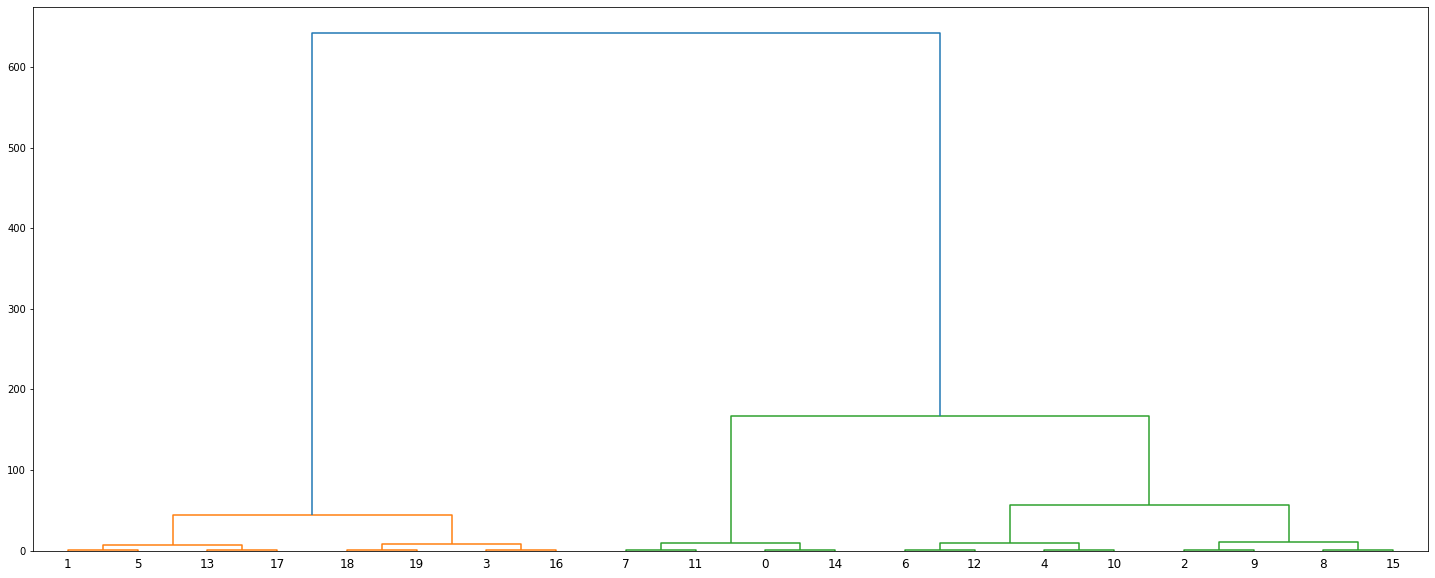

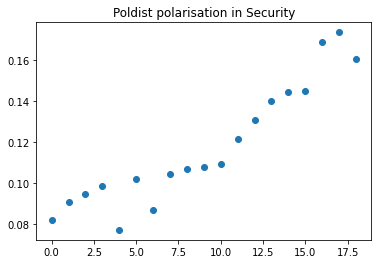

****** CENTROID ******
(19, 4)


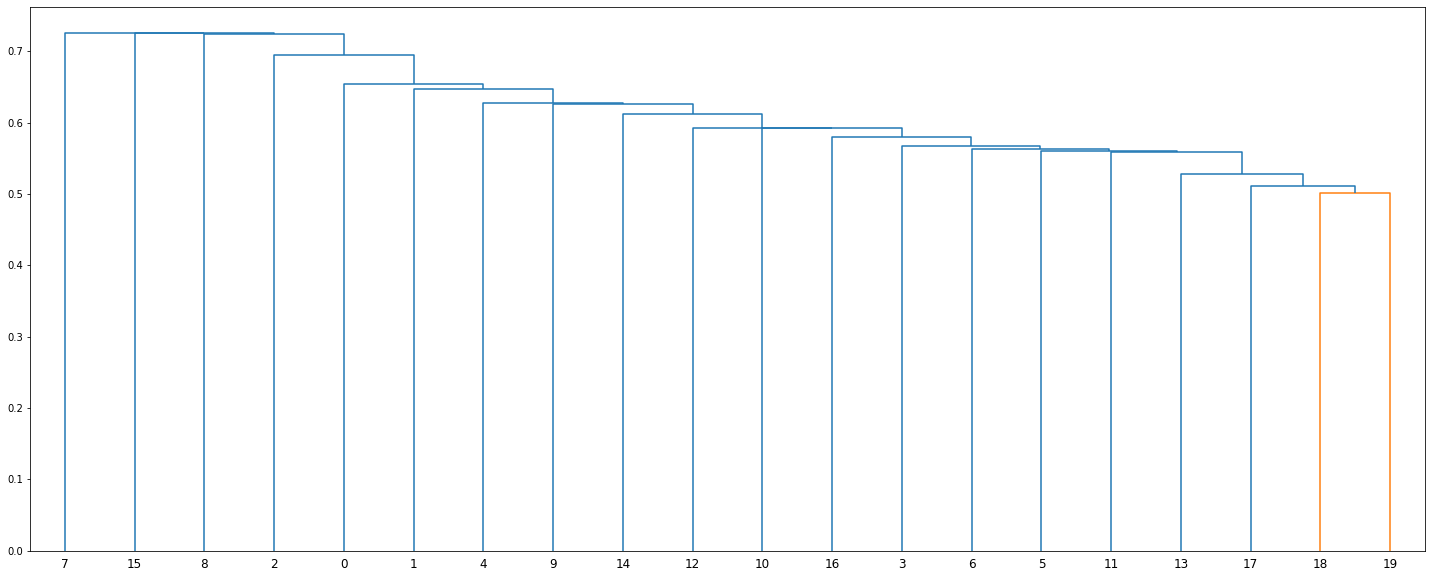

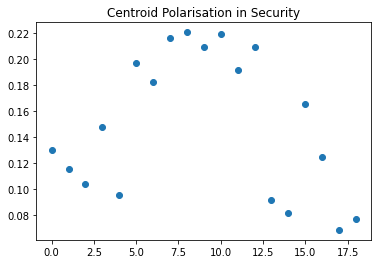

File saved to ../plots/Security_rfdist_vs_alpha.png!


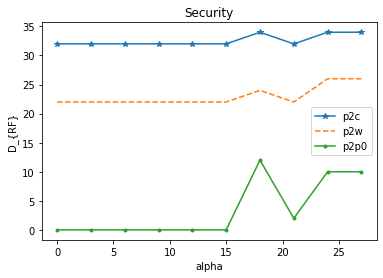

====== Security and defence ======
Total number of endorsers: 683
Number of unique endorsers: 504
Number of proposals: 35
File saved to ../plots/Security_and_defence_bim_net.png!


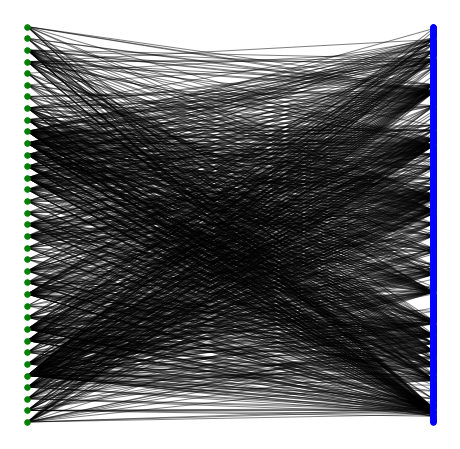

File saved to ../plots/Security_and_defence_uni_net.png!


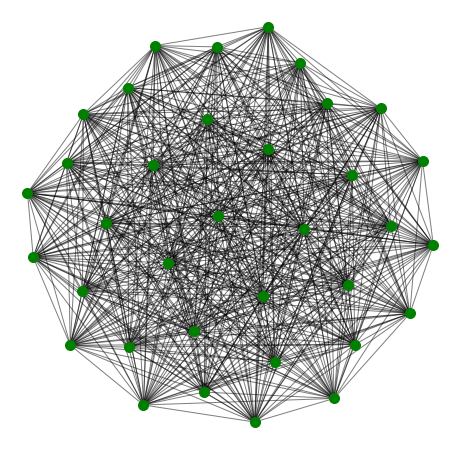

595 595.0
(595,)
****** WARD ******


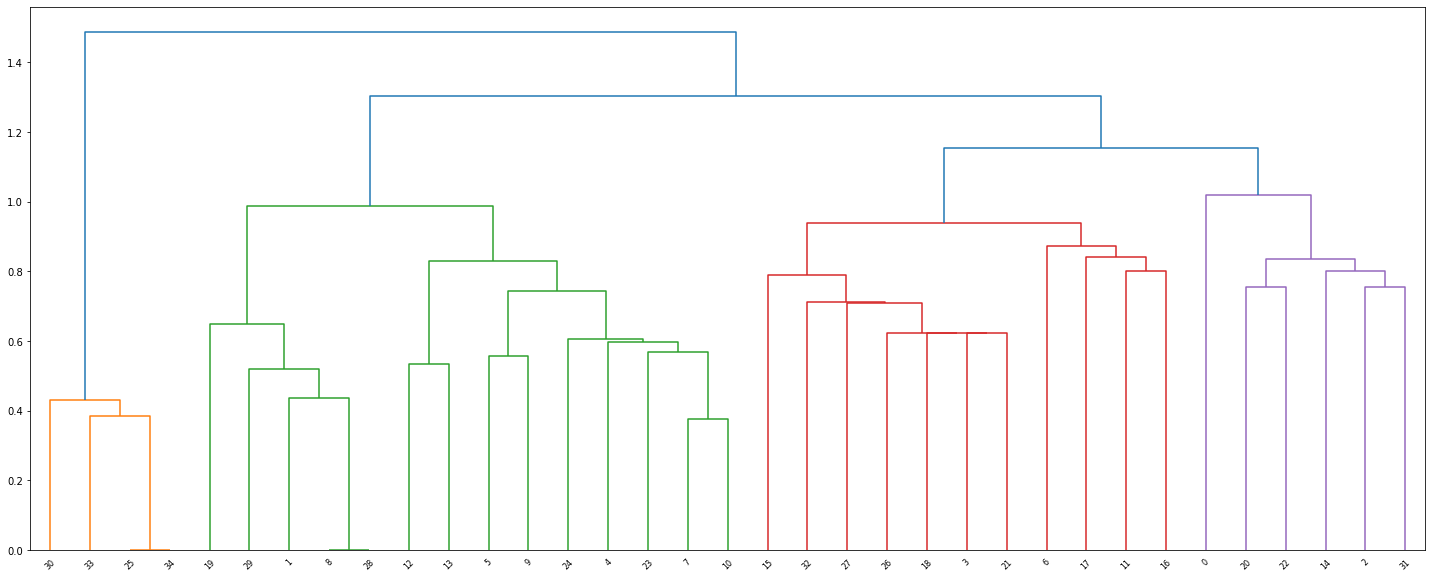

****** POLDIST ******


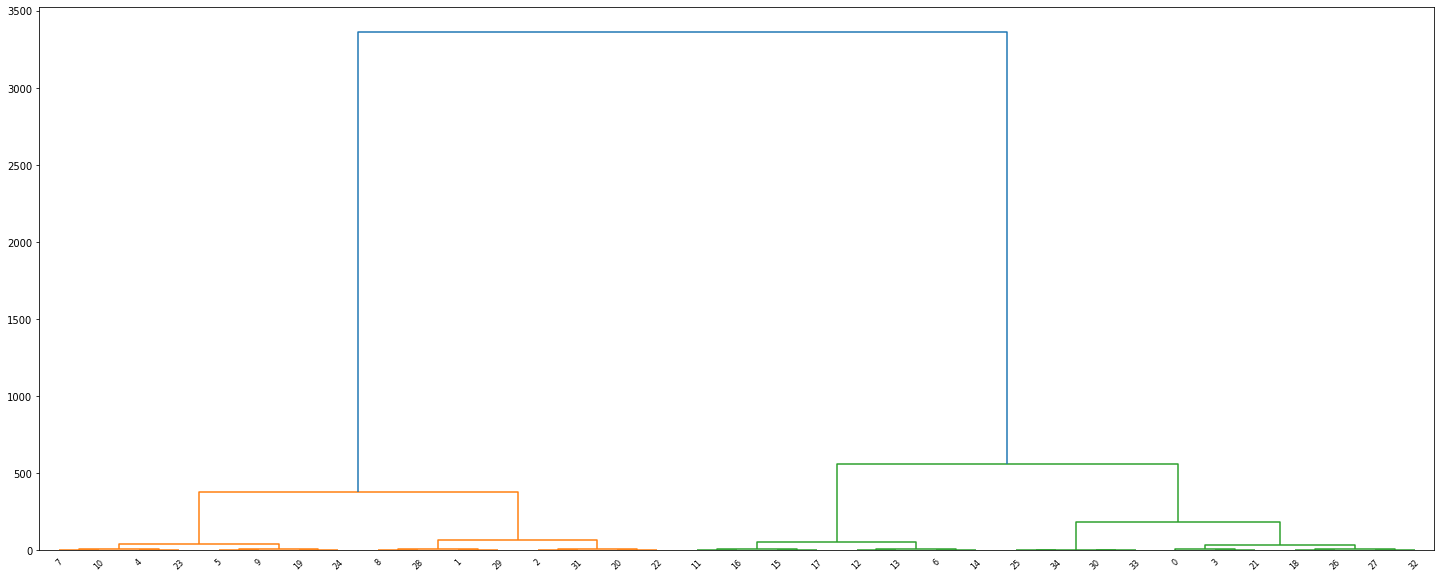

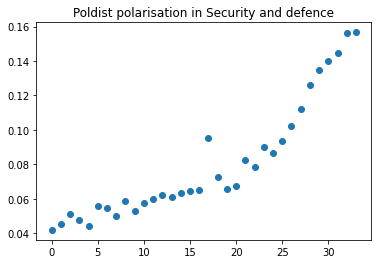

****** CENTROID ******
(34, 4)on 33/33...


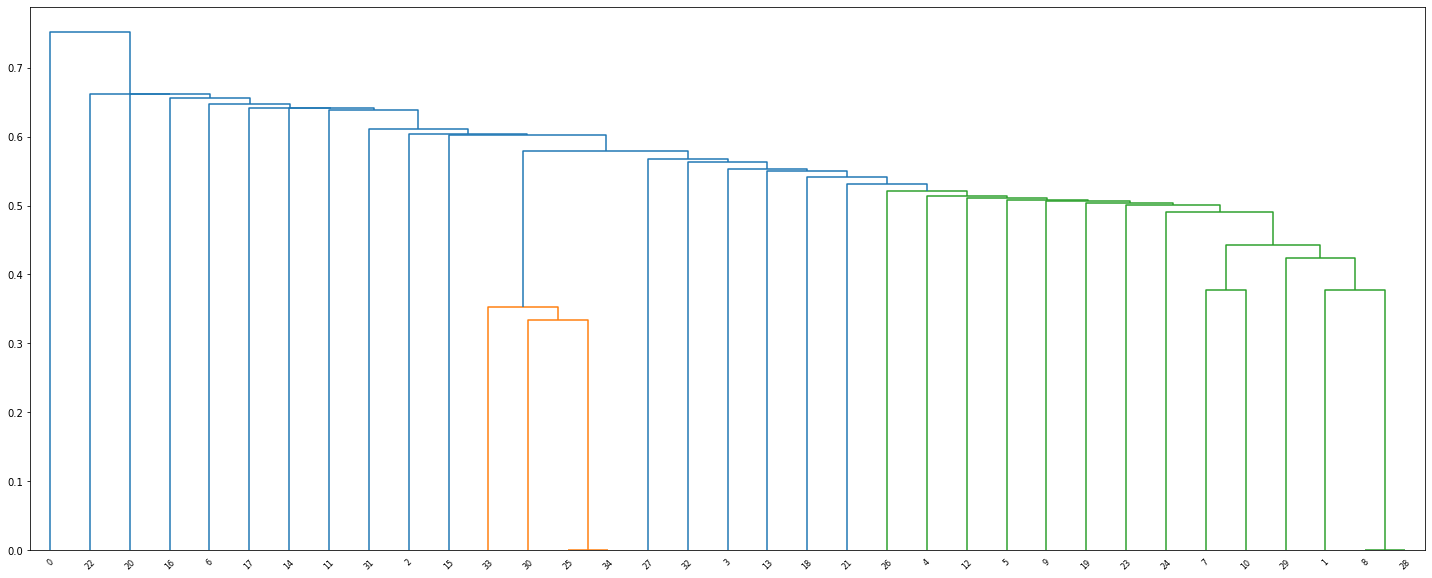

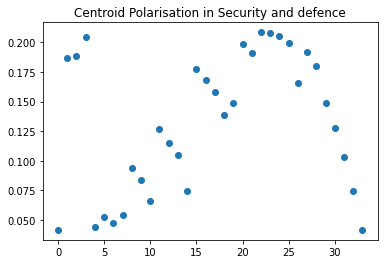

/home/bambusito/Desktop/backup/Dropbox/masterBCN/TFM/polarisation/utils/clustering.py:284: RuntimeWarning: overflow encountered in long_scalars
  d_pol_xy_i = d_xy_i*(size_i*(size_x+size_y)**(1+alpha)+


File saved to ../plots/Security_and_defence_rfdist_vs_alpha.png!


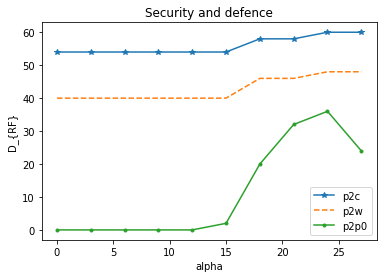

====== Legal migration and integration ======
Total number of endorsers: 138
Number of unique endorsers: 90
Number of proposals: 25
File saved to ../plots/Legal_migration_and_integration_bim_net.png!


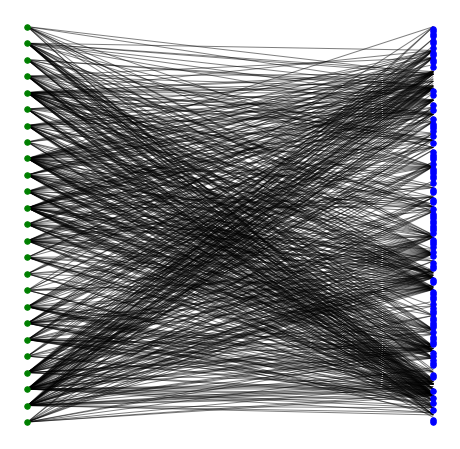

File saved to ../plots/Legal_migration_and_integration_uni_net.png!


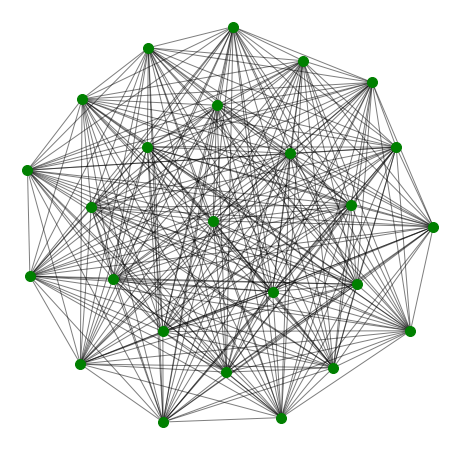

300 300.0
(300,)
****** WARD ******


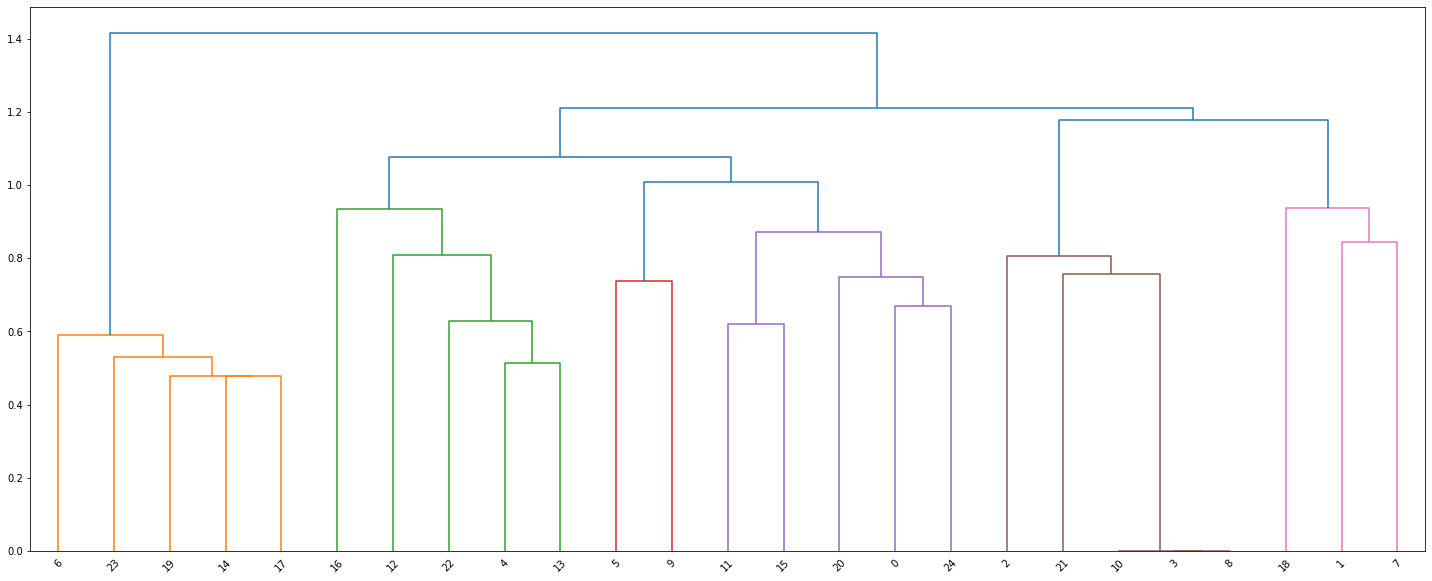

****** POLDIST ******


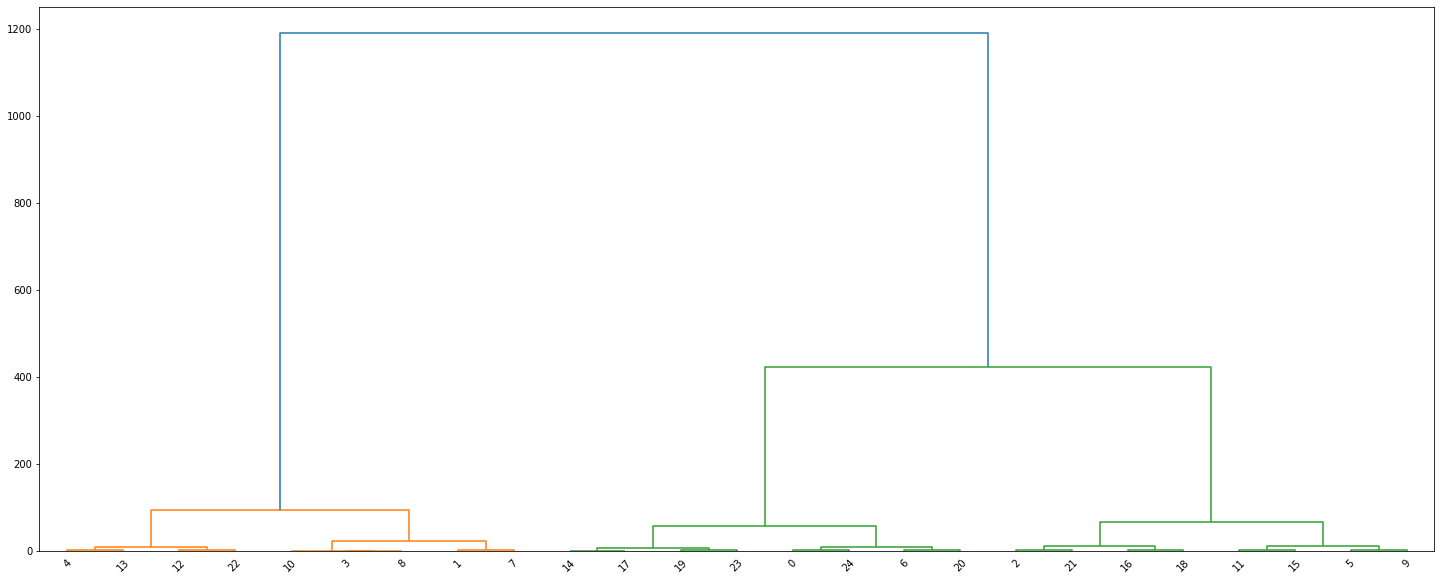

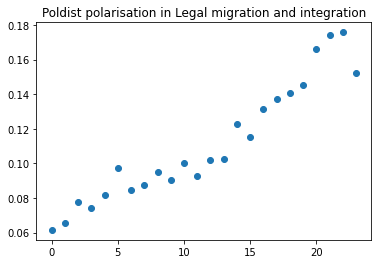

****** CENTROID ******
(24, 4)on 23/23...


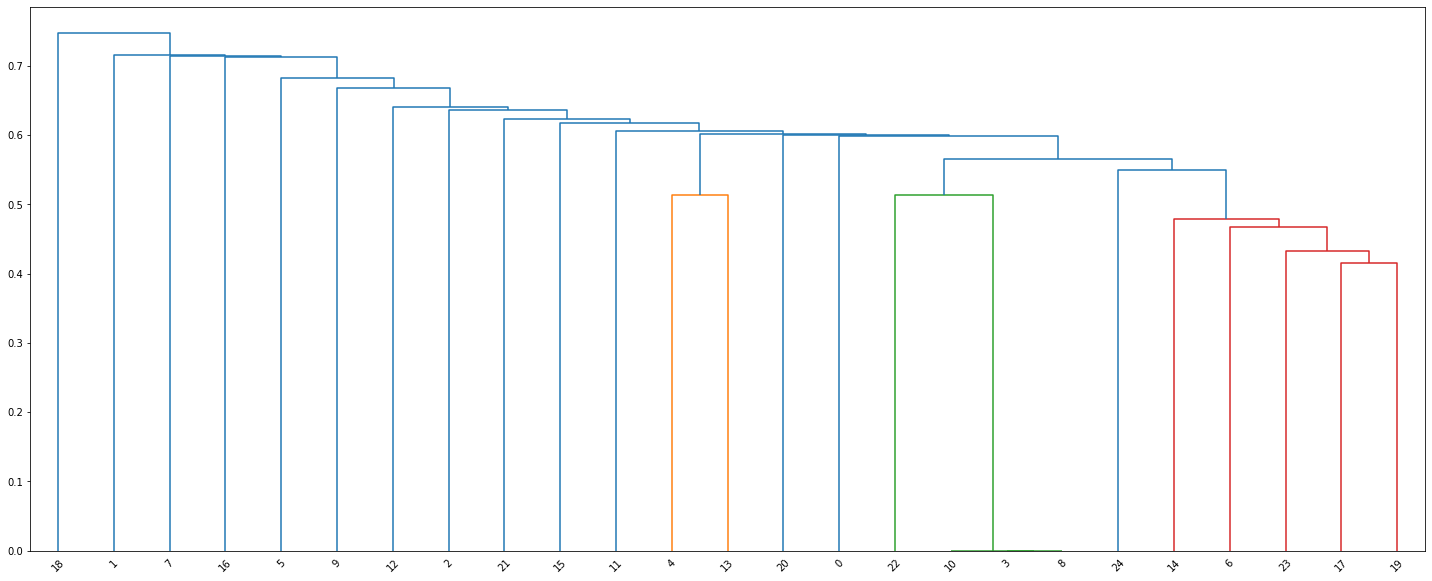

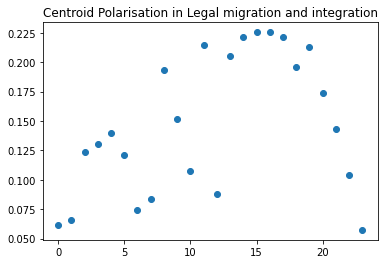

/home/bambusito/Desktop/backup/Dropbox/masterBCN/TFM/polarisation/utils/clustering.py:284: RuntimeWarning: overflow encountered in long_scalars
  d_pol_xy_i = d_xy_i*(size_i*(size_x+size_y)**(1+alpha)+


File saved to ../plots/Legal_migration_and_integration_rfdist_vs_alpha.png!


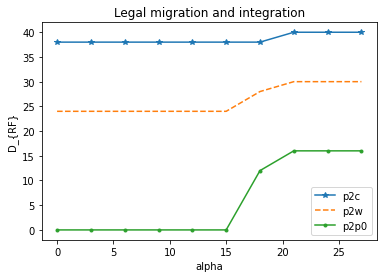

====== Integrated Border Management ======
Total number of endorsers: 26
Number of unique endorsers: 26
Number of proposals: 3
====== Asylum and Migration ======
Total number of endorsers: 418
Number of unique endorsers: 265
Number of proposals: 49
File saved to ../plots/Asylum_and_Migration_bim_net.png!


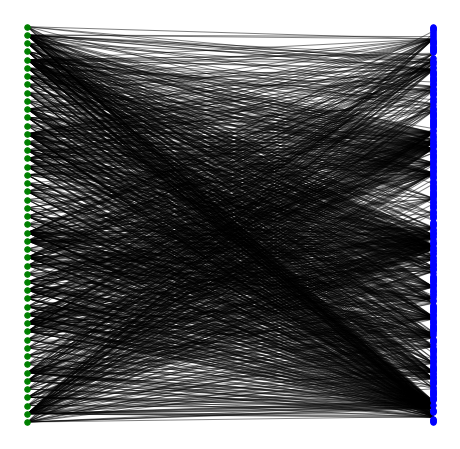

File saved to ../plots/Asylum_and_Migration_uni_net.png!


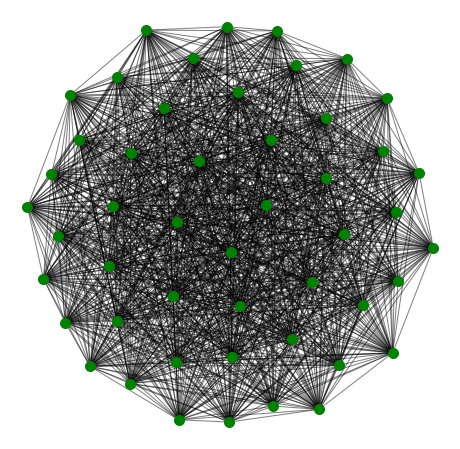

1176 1176.0
(1176,)
****** WARD ******


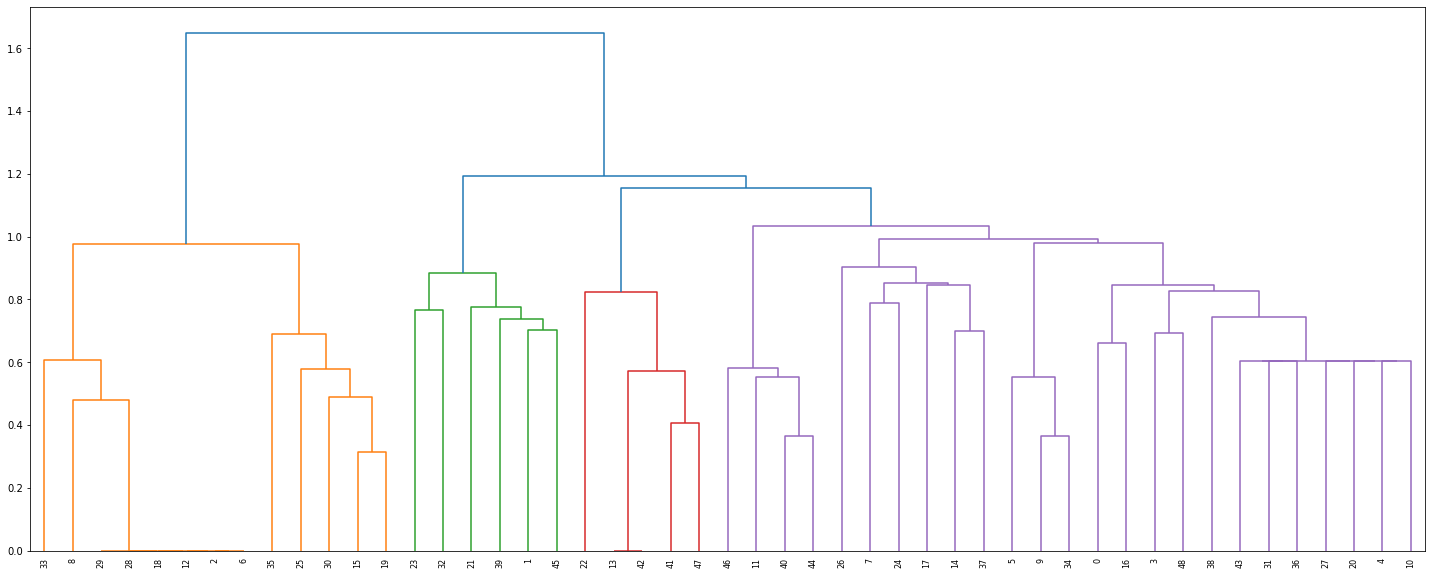

****** POLDIST ******


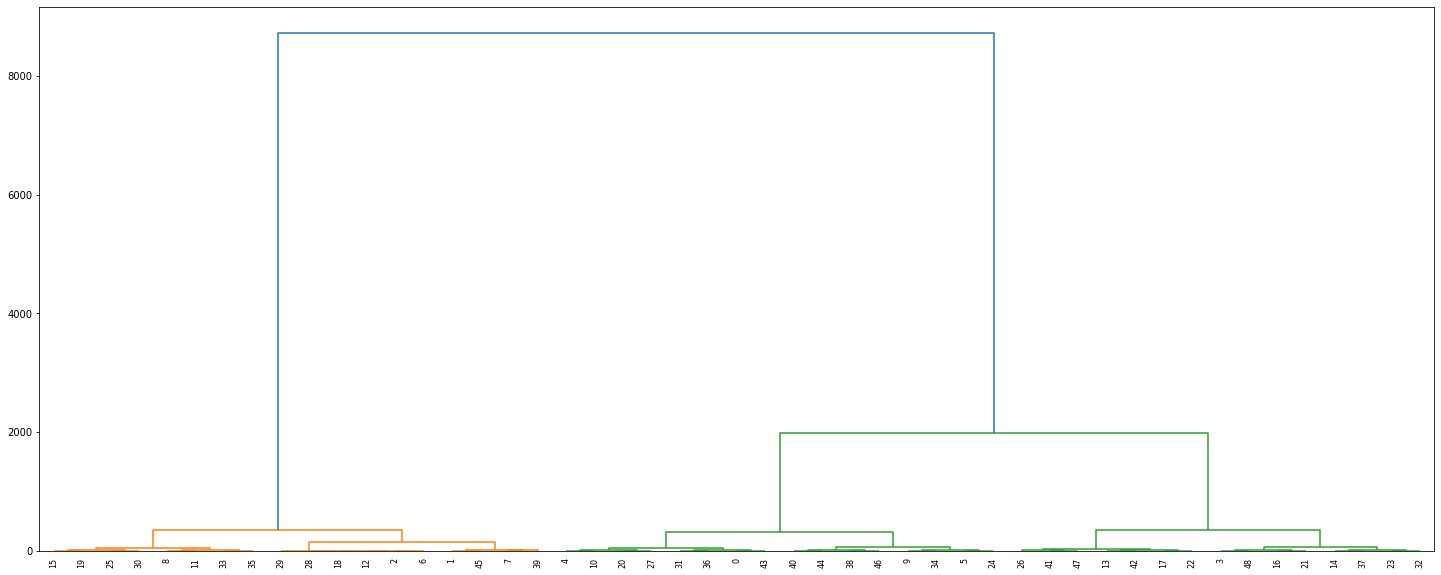

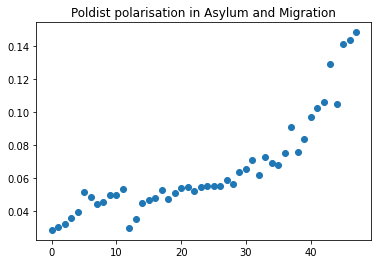

****** CENTROID ******
(48, 4)on 47/47...


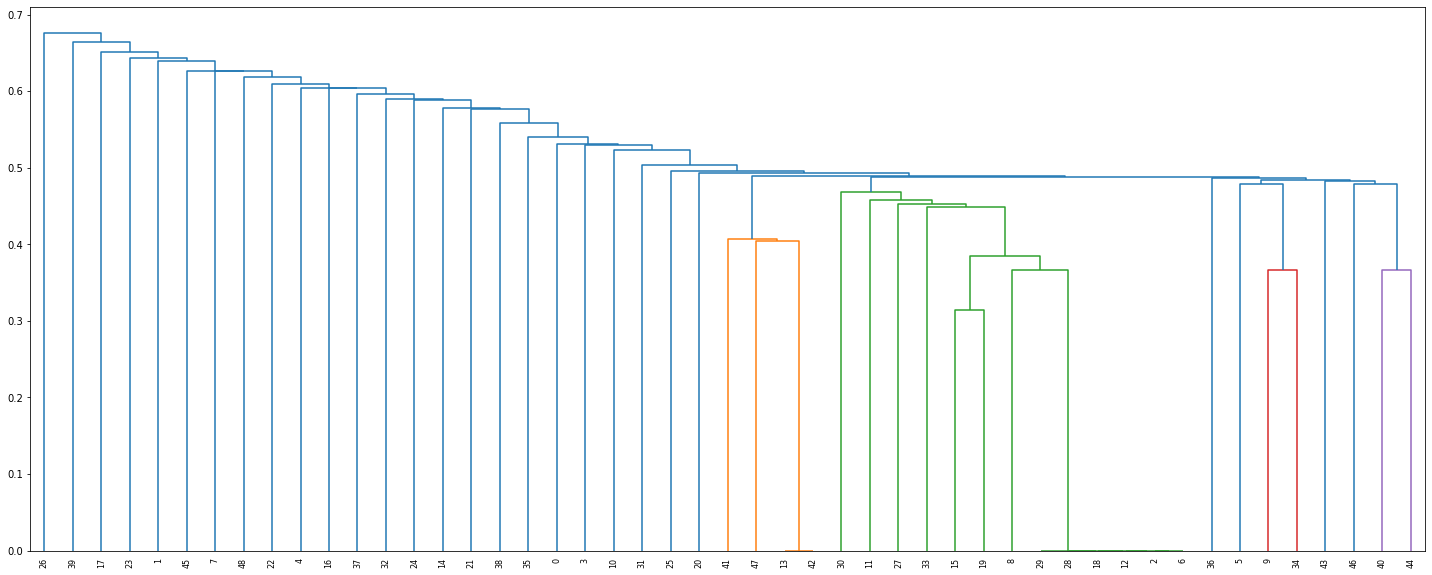

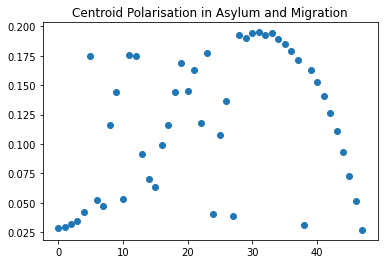

/home/bambusito/Desktop/backup/Dropbox/masterBCN/TFM/polarisation/utils/clustering.py:284: RuntimeWarning: overflow encountered in long_scalars
  d_pol_xy_i = d_xy_i*(size_i*(size_x+size_y)**(1+alpha)+


File saved to ../plots/Asylum_and_Migration_rfdist_vs_alpha.png!


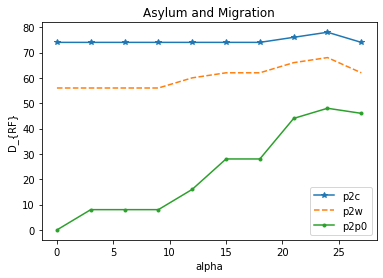

====== Culture ======
Total number of endorsers: 259
Number of unique endorsers: 173
Number of proposals: 27
File saved to ../plots/Culture_bim_net.png!


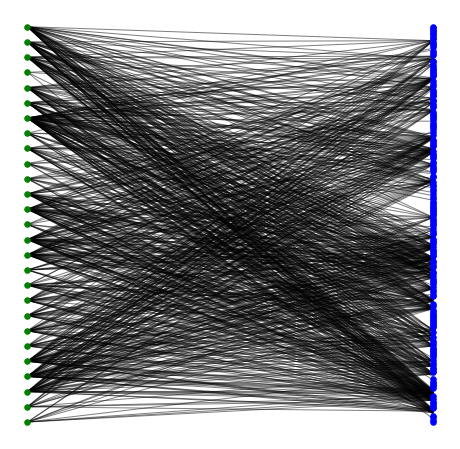

File saved to ../plots/Culture_uni_net.png!


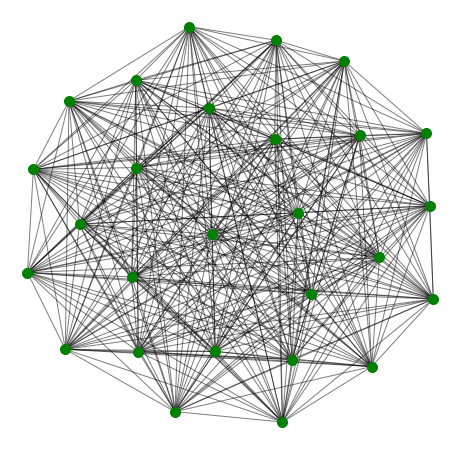

351 351.0
(351,)
****** WARD ******


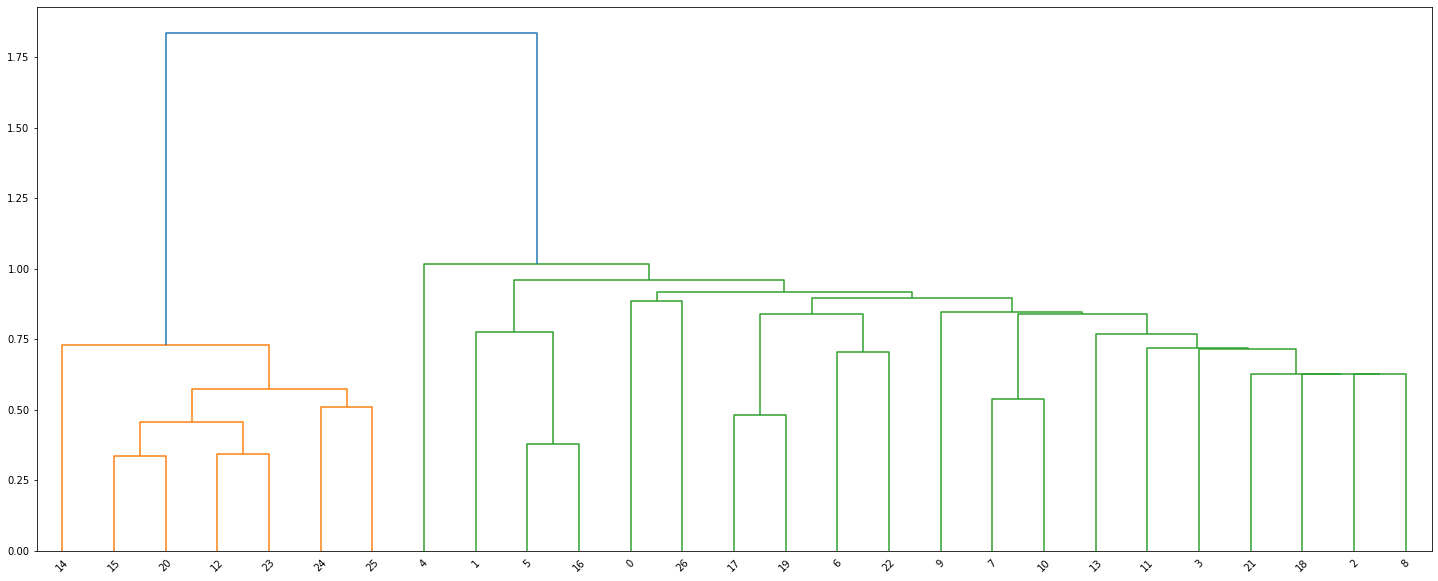

****** POLDIST ******


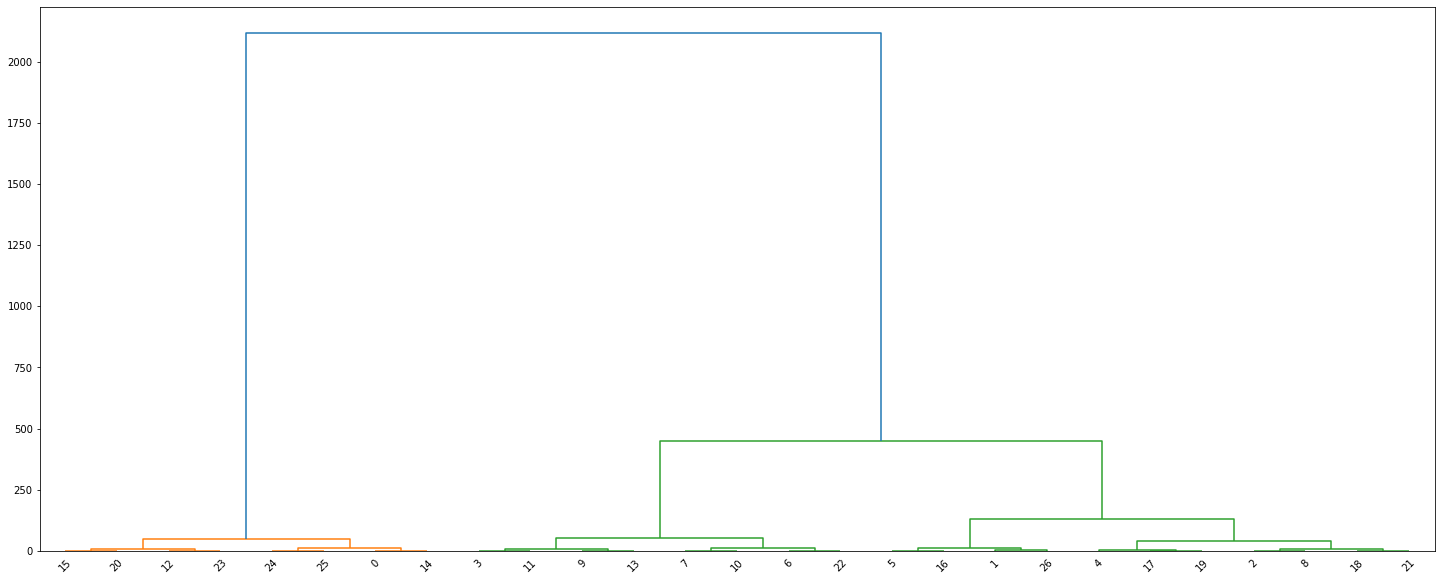

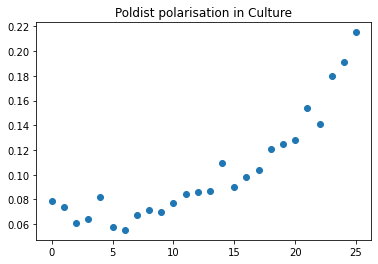

****** CENTROID ******
(26, 4)on 25/25...


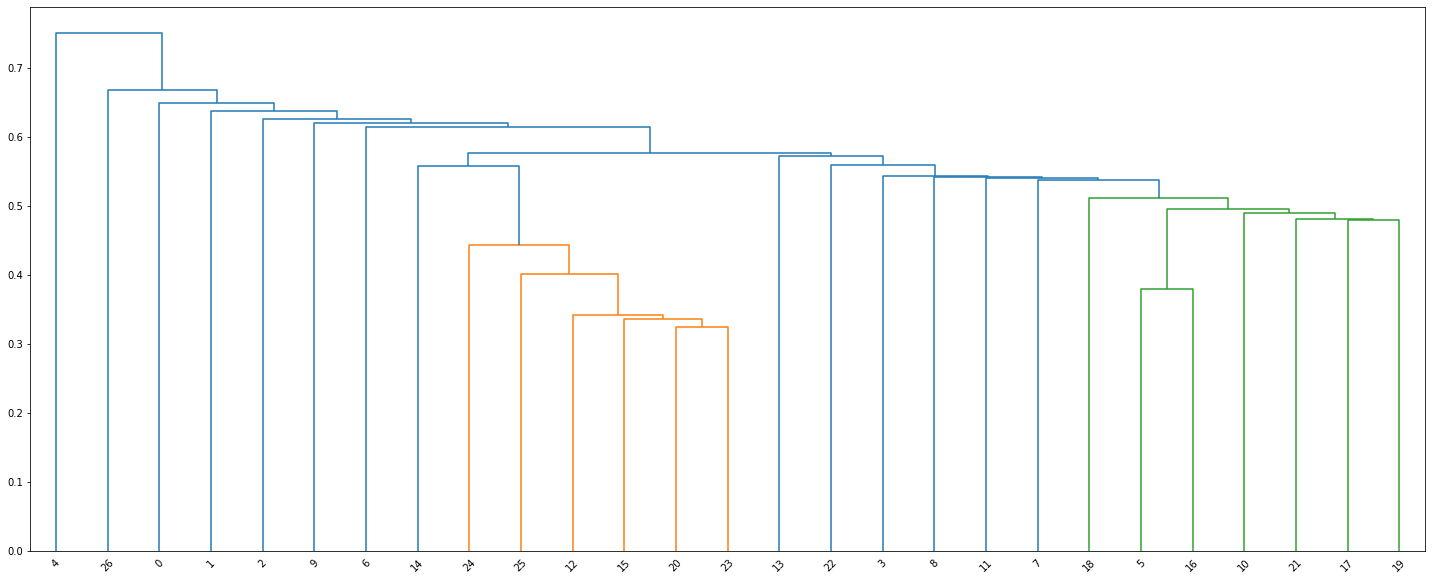

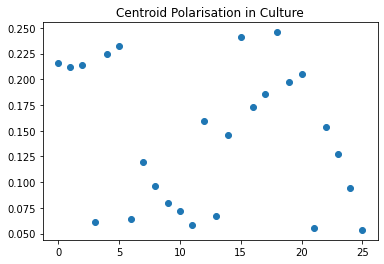

/home/bambusito/Desktop/backup/Dropbox/masterBCN/TFM/polarisation/utils/clustering.py:284: RuntimeWarning: overflow encountered in long_scalars
  d_pol_xy_i = d_xy_i*(size_i*(size_x+size_y)**(1+alpha)+


File saved to ../plots/Culture_rfdist_vs_alpha.png!


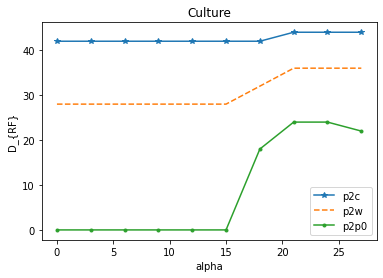

====== Education ======
Total number of endorsers: 1400
Number of unique endorsers: 994
Number of proposals: 72
====== Sport ======
Total number of endorsers: 2
Number of unique endorsers: 2
Number of proposals: 1
====== Youth  ======
Total number of endorsers: 26
Number of unique endorsers: 25
Number of proposals: 10


In [41]:
for t in topics:
    fname = "_".join(t.split(" "))
    print(f"====== {t} ======")
    subdf = df_by_topic(t, cols_to_keep)
    x, y, x2vect, x2y = get_nodes(subdf)
    if (len(x) < 60) &  (len(x) > 10):
        B, pos = bimodal_net(x, y, x2y, fname2save="../plots/"+fname+"_bim_net.png")
        unimodal_net(x, y, x2vect, fname2save="../plots/"+fname+"_uni_net.png")
        d = cond_dist_matrix(x, x2vect)
        print(f"****** WARD ******")
        z_ward, _ = agglomerative_clustering(d, method='ward')
        #print(z_ward.shape)
        fig = plt.figure(figsize=(25, 10))
        dn = dendrogram(z_ward)
        plt.show()
        print(f"****** POLDIST ******")
        z_pol, pol = agglomerative_clustering(d, method='polarisation', alpha=1, K=None)
        #print(z_pol.shape)
        fig = plt.figure(figsize=(25, 10))
        dn = dendrogram(z_pol)
        plt.show()
        plt.plot(pol, "o")
        plt.title("Poldist polarisation in " + t)
        plt.show()
        print(f"****** CENTROID ******")
        z_ctr, pol = agglomerative_clustering(d, method='centroid', alpha=1, K=None)
        print(z_ctr.shape)
        fig = plt.figure(figsize=(25, 10))
        dn = dendrogram(z_ctr)
        plt.show()
        plt.plot(pol, "o")
        plt.title("Centroid Polarisation in " + t)
        plt.show()
        dist_p2c, dist_p2w, dist_p2p0 = tree_dists(d, x)
        fname2save = "../plots/"+fname+"_rfdist_vs_alpha.png"
        dist_plots(alphas, dist_p2c, dist_p2w, dist_p2p0, title=t, fname2save=fname2save)